<a href="https://colab.research.google.com/github/jaysmerrill/Yaquina_Bay_Seiching/blob/main/seiche_prediction_rtdata_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ================================================
# Colab: Seiche forecast with PatchTST (XGB feature pick, forced baro_var4h)
# ================================================


# ============================================================
# Real-time forcings (no parquet) + var_wl (20–30 min bandpass → X-hour variance)
# Sources: NOAA CO-OPS 9435380 (WL, wind, air pressure), NDBC 46050 (stdmet, swden), HMSC (baro gap-fill)
# ============================================================

# -- If needed (Colab usually has torch already):
!pip -q install xgboost

import io, gzip, re, json, os, time, math, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from contextlib import nullcontext
from sklearn.metrics import r2_score
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

!pip -q install plotly scipy
from scipy.signal import butter, filtfilt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =========================
# UTC HYGIENE — ONE DROP-IN
# Paste this block right after: from urllib3.util.retry import Retry
# No other edits needed in your code.
# =========================
import pandas as pd, numpy as np

# ---- helpers ----
def to_utc_ts(x) -> pd.Timestamp:
    if x is None: return pd.NaT
    t = pd.to_datetime(x, errors="coerce")
    if pd.isna(t): return pd.NaT
    if isinstance(t, pd.DatetimeIndex):
        t = t[0]
    if t.tz is None:
        return t.tz_localize("UTC")
    return t.tz_convert("UTC")

def to_utc_index(idx) -> pd.DatetimeIndex:
    if not isinstance(idx, pd.DatetimeIndex):
        idx = pd.to_datetime(idx, errors="coerce")
    if idx.tz is None:
        return idx.tz_localize("UTC")
    return idx.tz_convert("UTC")

def normalize_time_col(df: pd.DataFrame, col="time") -> pd.DataFrame:
    if df is None or not isinstance(df, pd.DataFrame) or len(df)==0 or col not in df.columns:
        return df
    out = df.copy()
    out[col] = pd.to_datetime(out[col], errors="coerce", utc=True)
    return (out.dropna(subset=[col]).sort_values(col).drop_duplicates(col).reset_index(drop=True))

# ---- wrap your parsers so they always emit UTC-aware 'time' ----
if "parse_stdmet_text" in globals():
    _old_parse_stdmet_text = parse_stdmet_text
    def parse_stdmet_text(txt: str) -> pd.DataFrame:
        df = _old_parse_stdmet_text(txt)
        return normalize_time_col(df, "time")
    globals()["parse_stdmet_text"] = parse_stdmet_text

if "parse_swden_year" in globals():
    _old_parse_swden_year = parse_swden_year
    def parse_swden_year(txt: str) -> pd.DataFrame:
        df = _old_parse_swden_year(txt)
        return normalize_time_col(df, "time")
    globals()["parse_swden_year"] = parse_swden_year

if "parse_noaa_wind_csv" in globals():
    _old_parse_noaa_wind_csv = parse_noaa_wind_csv
    def parse_noaa_wind_csv(txt: str) -> pd.DataFrame:
        df = _old_parse_noaa_wind_csv(txt)
        return normalize_time_col(df, "time")
    globals()["parse_noaa_wind_csv"] = parse_noaa_wind_csv

if "parse_noaa_wl_csv" in globals():
    _old_parse_noaa_wl_csv = parse_noaa_wl_csv
    def parse_noaa_wl_csv(txt: str) -> pd.DataFrame:
        df = _old_parse_noaa_wl_csv(txt)
        return normalize_time_col(df, "time")
    globals()["parse_noaa_wl_csv"] = parse_noaa_wl_csv

if "parse_hmsc_dat_avgbp_pa" in globals():
    _old_parse_hmsc_dat = parse_hmsc_dat_avgbp_pa
    def parse_hmsc_dat_avgbp_pa(txt: str) -> pd.DataFrame:
        df = _old_parse_hmsc_dat(txt)
        return normalize_time_col(df, "time")
    globals()["parse_hmsc_dat_avgbp_pa"] = parse_hmsc_dat_avgbp_pa

# ---- normalize any DataFrames already built ----
def _utcify_df(name):
    if name in globals() and isinstance(globals()[name], pd.DataFrame) and len(globals()[name]):
        globals()[name] = normalize_time_col(globals()[name], "time")

for _nm in [
    "df_stdmet","df_swden","df_noaa_wind","df_wl6","df_varWL",
    "df_air","df_baro","df_baro_var","df_wind","df_46050","df_swd",
    "df_hmsc","df_hmsc_bp","df_all"
]:
    _utcify_df(_nm)

# ---- normalize common timestamps / ranges if they exist ----
for _tn in ["PRED_START","PRED_END","TRAIN_END","VAL_END","fill_start","fill_end","ap_start","ap_end"]:
    if _tn in globals():
        globals()[_tn] = to_utc_ts(globals()[_tn])

# Rebuild hourly_grid if fill_start/end exist
if "fill_start" in globals() and "fill_end" in globals() and pd.notna(globals()["fill_start"]) and pd.notna(globals()["fill_end"]):
    fs = to_utc_ts(globals()["fill_start"]); fe = to_utc_ts(globals()["fill_end"])
    globals()["hourly_grid"] = pd.date_range(fs.floor("H"), fe.ceil("H"), freq="H", tz="UTC")

# Rebuild baro hourly_grid if df_air exists
if "df_air" in globals() and isinstance(df_air, pd.DataFrame) and len(df_air):
    df_air = normalize_time_col(df_air, "time")
    ap_start = to_utc_ts(df_air["time"].min())
    ap_end   = to_utc_ts(df_air["time"].max())
    globals()["ap_start"] = ap_start; globals()["ap_end"] = ap_end
    globals()["hourly_grid"] = pd.date_range(ap_start.floor("H"), ap_end.ceil("H"), freq="H", tz="UTC")

# Rebuild modeling grid t_grid if inputs exist
def _maybe_tgrid():
    t0c=[]; t1c=[]
    for nm in ["df_varWL","df_swd","df_46050","df_wind","df_baro","df_baro_var"]:
        if nm in globals() and isinstance(globals()[nm], pd.DataFrame) and len(globals()[nm]):
            t0c.append(to_utc_ts(globals()[nm]["time"].min()))
            t1c.append(to_utc_ts(globals()[nm]["time"].max()))
    if t0c and t1c:
        t0 = max([t for t in t0c if pd.notna(t)])
        t1 = min([t for t in t1c if pd.notna(t)])
        if pd.notna(t0) and pd.notna(t1) and t1>t0:
            step = globals().get("DT_MINUTES", 6)
            return pd.date_range(t0, t1, freq=f"{step}min", tz="UTC")
    return None

tg = _maybe_tgrid()
if tg is not None:
    globals()["t_grid"] = tg

# Wrap interp helpers to enforce UTC indices
if "_interp_to_grid_series" in globals():
    _old_interp = _interp_to_grid_series
    def _interp_to_grid_series(times, values, grid):
        times = to_utc_index(times); grid = to_utc_index(grid)
        s = pd.Series(values, index=times)
        u = s.reindex(pd.to_datetime(sorted(set(s.index).union(set(grid)))))
        u = u.interpolate(method="time", limit_area="inside")
        return u.reindex(grid).to_numpy()
    globals()["_interp_to_grid_series"] = _interp_to_grid_series

if "interp_timegrid" in globals():
    _old_interp2 = interp_timegrid
    def interp_timegrid(t_src: pd.Series, x_src: np.ndarray, t_grid: pd.DatetimeIndex) -> np.ndarray:
        t_src = to_utc_index(t_src); t_grid = to_utc_index(t_grid)
        s = pd.Series(x_src, index=t_src)
        u = s.reindex(pd.to_datetime(sorted(set(s.index).union(set(t_grid)))))
        u = u.interpolate(method="time", limit_area="inside")
        return u.reindex(t_grid).to_numpy()
    globals()["interp_timegrid"] = interp_timegrid

# Gap utilities and EQ decay: enforce UTC
if "gap_intervals" in globals():
    _old_gap = gap_intervals
    def gap_intervals(t: pd.Series, x: np.ndarray, min_gap_hours: float):
        t = to_utc_index(t)
        return _old_gap(t, x, min_gap_hours)
    globals()["gap_intervals"] = gap_intervals

if "merge_intervals" in globals():
    _old_merge = merge_intervals
    def merge_intervals(intervals):
        out = _old_merge(intervals)
        return [(to_utc_ts(a), to_utc_ts(b)) for a,b in out]
    globals()["merge_intervals"] = merge_intervals

if "build_eq_decay_series" in globals():
    _old_eq = build_eq_decay_series
    def build_eq_decay_series(t_grid: pd.DatetimeIndex, eq_events):
        t_grid = to_utc_index(t_grid)
        eq_fixed = []
        for t0_evt, M in (eq_events or []):
            eq_fixed.append((to_utc_ts(t0_evt), M))
        return _old_eq(t_grid, eq_fixed)
    globals()["build_eq_decay_series"] = build_eq_decay_series

print("✅ UTC hygiene applied (tz-aware UTC throughout). No other edits required.")



# -------------------
# USER KNOBS
# -------------------
YEARS                = list(range(2008, pd.Timestamp.utcnow().year + 1))
DT_MINUTES           = 6  # common model grid
WL_BAND_MIN_MIN      = 20.0
WL_BAND_MAX_MIN      = 30.0
VAR_WIN_HOURS        = 2.0     # <-- default window for variance of band-passed WL (tweakable)
NOAA_STATION         = "9435380"  # Newport / South Beach
NOAA_BEGIN_DATE      = "20080101"
NOAA_END_DATE        = pd.Timestamp.utcnow().strftime("%Y%m%d")
NOAA_CHUNK_DAYS      = 365

# HMSC monthly archive (baro gap fill for NOAA air_pressure ≥3h gaps; <3h: spline)
HMSC_UTC_OFFSET_H    = +8
INHG_TO_PA           = 3386.389

# NDBC buoy 46050
BUOY                 = "46050"

# Optional preview window for plots
PRED_START           = None  # e.g., pd.Timestamp("2022-11-01")
PRED_END             = None  # e.g., pd.Timestamp("2022-12-15")


def _make_session():
    s = requests.Session()
    retry = Retry(total=4, backoff_factor=0.6, status_forcelist=(429,500,502,503,504),
                  allowed_methods=["HEAD","GET","OPTIONS"], raise_on_status=False)
    s.headers.update({"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) RealtimeForcings/1.0", "Accept":"*/*"})
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://", HTTPAdapter(max_retries=retry))
    return s
session = _make_session()

def _datestr(dt) -> str:
    return pd.Timestamp(dt).strftime("%Y%m%d")

# -------------------
# NOAA CO-OPS: Water Level (6-min) + bandpass(20–30min) + centered rolling variance -> var_wl
# -------------------
def parse_noaa_wl_csv(txt:str)->pd.DataFrame:
    if txt.strip().lower().startswith("error"):
        return pd.DataFrame(columns=["time","wl"])
    df = pd.read_csv(io.StringIO(txt))
    if df.shape[1] < 2: return pd.DataFrame(columns=["time","wl"])
    df.columns = [str(c).strip().lower().replace("  "," ") for c in df.columns]
    tcol=None
    for k in ("date time","date_time","time","t","date"):
        if k in df.columns: tcol=k; break
    if tcol is None: return pd.DataFrame(columns=["time","wl"])
    df["time"] = pd.to_datetime(df[tcol], errors="coerce", utc=True).dt.tz_localize(None)
    vcol=None
    for k in ("water level","water_level","wl","v"):
        if k in df.columns: vcol=k; break
    if vcol is None: vcol = df.columns[1]
    df["wl"] = pd.to_numeric(df[vcol], errors="coerce")
    out = df[["time","wl"]].dropna(subset=["time"]).sort_values("time").drop_duplicates("time")
    out.loc[(out["wl"]<-50)|(out["wl"]>50),"wl"]=np.nan
    return out.reset_index(drop=True)

def fetch_noaa_wl(begin_date:str, end_date:str, station:str, days_per_chunk:int=31)->pd.DataFrame:
    start = pd.to_datetime(begin_date, format="%Y%m%d"); end = pd.to_datetime(end_date, format="%Y%m%d")
    frames=[]
    cur=start
    while cur <= end:
        chunk_end = min(end, cur + pd.Timedelta(days=days_per_chunk-1))
        url = ("https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
               f"?begin_date={_datestr(cur)}&end_date={_datestr(chunk_end)}"
               f"&station={station}&product=water_level&datum=MLLW&time_zone=gmt&units=metric"
               f"&interval=6&application=RealtimeForcings&format=csv")
        try:
            r = session.get(url, timeout=90)
            if r.status_code==200 and r.content:
                dfc = parse_noaa_wl_csv(r.content.decode("utf-8","ignore"))
                if not dfc.empty: frames.append(dfc)
        except: pass
        cur = chunk_end + pd.Timedelta(days=1)
    if not frames: return pd.DataFrame(columns=["time","wl"])
    return pd.concat(frames, ignore_index=True).sort_values("time").drop_duplicates("time").reset_index(drop=True)

def bandpass_then_var(series:pd.DataFrame, val_col:str, dt_minutes:int,
                      band_min_min:float, band_max_min:float, var_win_h:float)->pd.DataFrame:
    if series.empty: return pd.DataFrame(columns=["time","var_wl"])
    t0,t1 = series["time"].min(), series["time"].max()
    grid = pd.date_range(t0.floor(f"{dt_minutes}min"), t1.ceil(f"{dt_minutes}min"), freq=f"{dt_minutes}min")
    s = series.set_index("time")[val_col].reindex(grid)
    s = s.interpolate(method="time", limit_area="inside")
    dt_sec = dt_minutes*60.0; fs=1.0/dt_sec
    f_lo = 1.0/(band_max_min*60.0)  # low cutoff = longer period edge
    f_hi = 1.0/(band_min_min*60.0)  # high cutoff = shorter period edge
    wn = [max(1e-6, f_lo/(fs/2.0)), min(0.999, f_hi/(fs/2.0))]
    b,a = butter(6, wn, btype="bandpass")
    x = s.to_numpy(dtype=float)
    if np.isnan(x).any():
        idx = np.arange(len(x)); good = np.isfinite(x);
        if good.any(): x[~good] = np.interp(idx[~good], idx[good], x[good])
    x_bp = filtfilt(b,a,x,method="gust")  # zero-phase
    win = max(3, int(round((var_win_h*60.0)/dt_minutes)))
    minp = max(2, int(0.8*win))
    var_series = pd.Series(x_bp, index=grid).rolling(window=win, center=True, min_periods=minp).var()
    return pd.DataFrame({"time":grid, "var_wl":var_series.astype("float32")}).dropna(subset=["time"]).reset_index(drop=True)

df_wl6  = fetch_noaa_wl(NOAA_BEGIN_DATE, NOAA_END_DATE, NOAA_STATION, days_per_chunk=31)
df_varWL = bandpass_then_var(df_wl6, "wl", DT_MINUTES, WL_BAND_MIN_MIN, WL_BAND_MAX_MIN, VAR_WIN_HOURS)
print("WL coverage:", (df_wl6["time"].min() if len(df_wl6) else None), "→", (df_wl6["time"].max() if len(df_wl6) else None), f"(n={len(df_wl6):,})")

# 1) Convert to cm
df_wl6 = df_wl6.copy()
df_wl6["wl_cm"] = df_wl6["wl"] * 100.0

# 2) Regular 6-min grid + interpolate NaN gaps ≤ 3h
dt_minutes = DT_MINUTES                     # e.g., 6
grid = pd.date_range(
    df_wl6["time"].min().floor(f"{dt_minutes}min"),
    df_wl6["time"].max().ceil(f"{dt_minutes}min"),
    freq=f"{dt_minutes}min"
)

s_cm = df_wl6.set_index("time")["wl_cm"].reindex(grid)

# Interpolate linearly only for internal gaps <= 3h
limit_samples = int(round(180 / dt_minutes))   # 3h = 180 min
nan_before = s_cm.isna().sum()
s_cm_filled = s_cm.interpolate(
    method="time",
    limit=limit_samples,
    limit_area="inside"         # internal gaps only
)
nan_after = s_cm_filled.isna().sum()
print(f"NaNs before: {nan_before}, after (post-fill ≤3h): {nan_after}")

# 3) 20–30 min bandpass in cm (same filter design as before)
dt_sec = dt_minutes * 60.0
fs     = 1.0 / dt_sec
f_lo   = 1.0 / (WL_BAND_MAX_MIN * 60.0)  # longer-period edge (e.g., 30 min)
f_hi   = 1.0 / (WL_BAND_MIN_MIN * 60.0)  # shorter-period edge (e.g., 20 min)
wn     = [max(1e-6, f_lo/(fs/2.0)), min(0.999, f_hi/(fs/2.0))]
b, a   = butter(6, wn, btype="bandpass")

x = s_cm_filled.to_numpy(dtype=float)
# If leading/trailing NaNs remain (gaps >3h), pad with edge values before filtfilt
if np.isnan(x).any():
    good = np.isfinite(x)
    if good.any():
        # Forward/backward fill just to let filtfilt run; they’ll be obvious on plots
        x = pd.Series(x).fillna(method="ffill").fillna(method="bfill").to_numpy()

x_bp_cm = filtfilt(b, a, x, method="gust")     # bandpassed WL in cm

# 4) Centered rolling variance (cm^2)
win = max(3, int(round((VAR_WIN_HOURS * 60.0) / dt_minutes)))
minp = max(2, int(0.8 * win))
var_cm2 = pd.Series(x_bp_cm, index=grid).rolling(window=win, center=True, min_periods=minp).var()

# 5) Pack outputs
df_wl6_cm_clean = pd.DataFrame({"time": grid, "wl_cm": s_cm_filled.values})
df_varWL_cm     = pd.DataFrame({"time": grid, "var_wl_cm2": var_cm2.astype("float32")})

print("WL (cm) coverage:", df_wl6_cm_clean["time"].min(), "→", df_wl6_cm_clean["time"].max(), f"(n={len(df_wl6_cm_clean):,})")
print("Var WL (cm^2) coverage:", df_varWL_cm["time"].min(), "→", df_varWL_cm["time"].max(), f"(n={len(df_varWL_cm):,})")

# # 6) Plot (top: WL in cm + bandpass; bottom: variance in cm^2)
# fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# ax0.plot(df_wl6_cm_clean["time"], df_wl6_cm_clean["wl_cm"], lw=1.2, label="Water level (cm)")
# ax0.plot(grid, x_bp_cm, lw=1.0, alpha=0.85, label=f"Bandpass {WL_BAND_MIN_MIN}–{WL_BAND_MAX_MIN} min (cm)")
# ax0.set_ylabel("WL (cm)")
# ax0.grid(True, alpha=0.3)
# ax0.legend(loc="best")
# ax0.set_title("NOAA Water Level (cm) with Bandpass + Rolling Variance (cm²)")

# ax1.plot(df_varWL_cm["time"], df_varWL_cm["var_wl_cm2"], lw=1.2)
# ax1.set_ylabel("Var(WL) (cm²)")
# ax1.set_xlabel("Time (UTC)")  # timestamps are UTC-naive in this pipeline
# ax1.grid(True, alpha=0.3)
# ax1.set_title(f"Centered rolling variance (window ≈ {VAR_WIN_HOURS:.1f} h)")

# plt.tight_layout()
# plt.show()

✅ UTC hygiene applied (tz-aware UTC throughout). No other edits required.
WL coverage: 2008-01-01 00:00:00 → 2025-10-29 21:06:00 (n=1,562,852)
NaNs before: 0, after (post-fill ≤3h): 0
WL (cm) coverage: 2008-01-01 00:00:00 → 2025-10-29 21:06:00 (n=1,562,852)
Var WL (cm^2) coverage: 2008-01-01 00:00:00 → 2025-10-29 21:06:00 (n=1,562,852)


NOAA coverage: 2008-01-01 00:00:00 → 2025-01-01 23:00:00 (n=138,914)
HMSC hourly coverage: 2010-10-23 16:00:00 → 2024-12-31 23:00:00 (n=124,400)
Merged (NOAA + HMSC≥3h gaps) coverage: 2008-01-01 00:00:00 → 2025-01-01 23:00:00 (n=149,064)


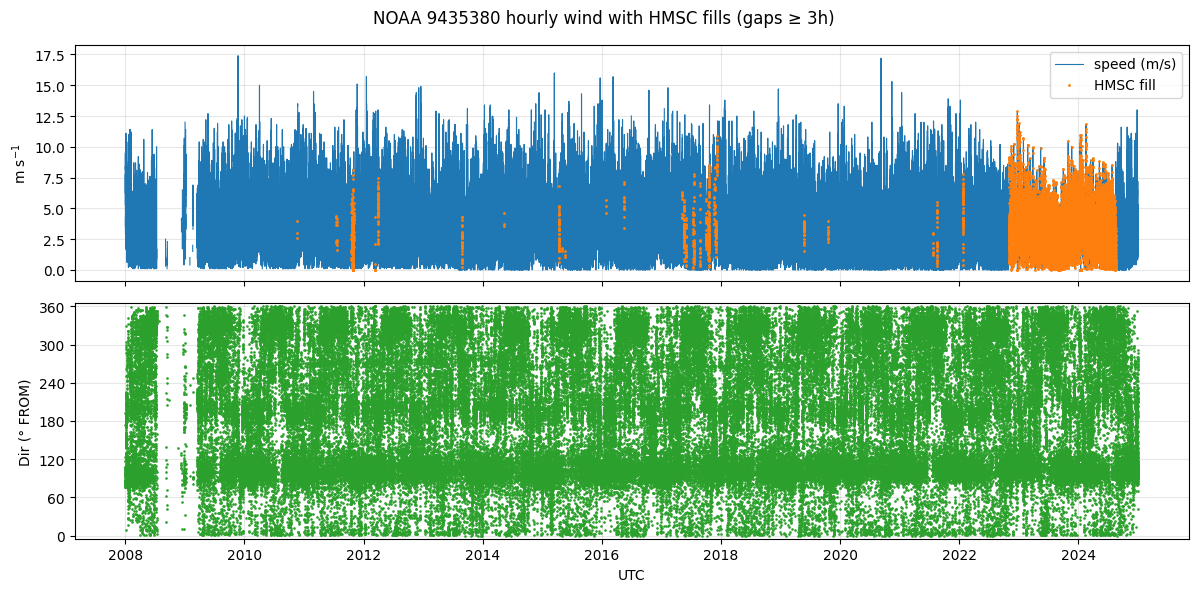

In [20]:
session = requests.Session()

# --- Config (edit as needed) ---
NOAA_BEGIN_DATE = "20080101"
NOAA_END_DATE   = "20250101"
NOAA_STATION    = "9435380"
NOAA_CHUNK_DAYS = 365

session = requests.Session()

def _datestr(dt) -> str:
    return pd.Timestamp(dt).strftime("%Y%m%d")

# ======================
# NOAA (hourly, metric)
# ======================
def parse_noaa_wind_csv(txt: str) -> pd.DataFrame:
    df = pd.read_csv(io.StringIO(txt))
    # Normalize headers
    df.columns = [re.sub(r"\s+", " ", str(c).strip()) for c in df.columns]

    # Time col: prefer "Date Time", else anything containing time/date
    lc = [c.lower() for c in df.columns]
    try:
        tcol = df.columns[lc.index("date time")]
    except ValueError:
        tcol = next((c for c in df.columns if any(k in c.lower() for k in ("date time","date_time","time","date","t"))),
                    df.columns[0])
    out = pd.DataFrame()
    out["time"] = pd.to_datetime(df[tcol], errors="coerce", utc=True).dt.tz_localize(None)

    # Select best numeric speed & direction columns
    def best_numeric(cands):
        best, nbest = None, -1
        for c in cands:
            vals = pd.to_numeric(df[c], errors="coerce")
            cnt  = np.isfinite(vals).sum()
            if cnt > nbest: best, nbest = c, cnt
        return best

    speed_cands = [c for c in df.columns if ("speed" in c.lower()) or (c.lower() == "s")]
    dir_cands   = [c for c in df.columns if ("direction" in c.lower()) or (c.lower() in ("dir","d"))]

    sp_col  = best_numeric(speed_cands) if speed_cands else None
    dir_col = best_numeric(dir_cands)   if dir_cands   else None

    out["speed"] = pd.to_numeric(df[sp_col], errors="coerce") if sp_col else np.nan
    out["dir"]   = pd.to_numeric(df[dir_col], errors="coerce") if dir_col else np.nan

    # QC
    out.loc[(out["speed"] < 0) | (out["speed"] > 100), "speed"] = np.nan
    out.loc[(out["dir"]   < 0) | (out["dir"]   > 360), "dir"]   = np.nan

    out = (out.dropna(subset=["time"])
              .sort_values("time")
              .drop_duplicates("time")
              .reset_index(drop=True))
    return out

def fetch_noaa_wind_dataframe(begin_date: str, end_date: str, station: str,
                              days_per_chunk: int = 365) -> pd.DataFrame:
    start = pd.to_datetime(begin_date, format="%Y%m%d")
    end   = pd.to_datetime(end_date,   format="%Y%m%d")
    frames, cur = [], start
    while cur <= end:
        chunk_end = min(end, cur + pd.Timedelta(days=days_per_chunk-1))
        url = ("https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
               f"?begin_date={_datestr(cur)}&end_date={_datestr(chunk_end)}"
               f"&station={station}&product=wind&time_zone=gmt&interval=h&units=metric"
               "&application=DataAPI_Sample&format=csv")
        try:
            r = session.get(url, timeout=90)
            if r.ok and r.content:
                dfc = parse_noaa_wind_csv(r.content.decode("utf-8", "ignore"))
                if not dfc.empty: frames.append(dfc)
        except Exception:
            pass
        cur = chunk_end + pd.Timedelta(days=1)

    if not frames:
        return pd.DataFrame(columns=["time","speed","dir"])

    df = (pd.concat(frames, ignore_index=True)
            .sort_values("time")
            .drop_duplicates("time")
            .reset_index(drop=True))
    return df

# ======================
# HMSC (5-min .dat)
# ======================
HMSC_BASE = "http://weather.hmsc.oregonstate.edu/weather/weatherproject/archive/{year}/HMSC_{year}{mm:02d}.dat"

def parse_hmsc_month(txt: str, year: int, month: int) -> pd.DataFrame:
    rows = []
    for ln in txt.splitlines():
        s = ln.strip()
        # Skip header/meta lines (quoted headers or empty)
        if not s or s.startswith('"TOA5"') or s.startswith('"TIMESTAMP"') or s.startswith('"TS"') or s.startswith('"",'):
            continue
        parts = [p.strip().strip('"') for p in s.split(",")]
        if len(parts) < 4:
            continue
        ts      = parts[0]          # "YYYY-MM-DD HH:MM:SS"
        aws_mph = parts[2]          # AWS (mph)
        awd_deg = parts[3]          # AWD (deg FROM north)

        # Time: local Pacific → UTC (naive)
        try:
            t_local = pd.to_datetime(ts, errors="coerce")
            if pd.isna(t_local):
                continue
            t_local = t_local.tz_localize("America/Los_Angeles", nonexistent="NaT", ambiguous="NaT")
            t_utc   = t_local.tz_convert("UTC").tz_localize(None)
        except Exception:
            continue

        try: spd = float(aws_mph)
        except: spd = np.nan
        try: dr  = float(awd_deg)
        except: dr  = np.nan

        if not (0 <= spd <= 200): spd = np.nan
        if not (0 <= dr  <= 360): dr  = np.nan

        rows.append((t_utc, spd, dr))

    if not rows:
        return pd.DataFrame(columns=["time","spd_mps","dir_deg"])

    df = pd.DataFrame(rows, columns=["time","aws_mph","awd_deg"])
    df["spd_mps"] = df["aws_mph"] * 0.44704              # mph → m/s
    df["dir_deg"] = df["awd_deg"]
    df = (df.drop(columns=["aws_mph","awd_deg"])
            .dropna(subset=["time"])
            .sort_values("time")
            .drop_duplicates("time")
            .reset_index(drop=True))
    # Keep only that month (safety)
    return df[(df["time"].dt.year == year) & (df["time"].dt.month == month)]

def fetch_hmsc_wind(begin_date: str, end_date: str) -> pd.DataFrame:
    start = pd.to_datetime(begin_date, format="%Y%m%d")
    end   = pd.to_datetime(end_date,   format="%Y%m%d")
    frames=[]
    for year in range(start.year, end.year+1):
        m0 = 1 if year > start.year else start.month
        m1 = 12 if year < end.year   else end.month
        for mm in range(m0, m1+1):
            url = HMSC_BASE.format(year=year, mm=mm)
            try:
                r = session.get(url, timeout=60)
                if r.status_code == 200 and r.content:
                    dfm = parse_hmsc_month(r.content.decode("utf-8","ignore"), year, mm)
                    if not dfm.empty: frames.append(dfm)
            except Exception:
                pass
    if not frames:
        return pd.DataFrame(columns=["time","spd_mps","dir_deg"])
    return (pd.concat(frames, ignore_index=True)
              .sort_values("time")
              .drop_duplicates("time")
              .reset_index(drop=True))

def vector_average_hourly(df_in: pd.DataFrame, tcol="time", spd_col="spd_mps", dir_col="dir_deg") -> pd.DataFrame:
    """Vector-average to exact top-of-hour timestamps in UTC."""
    if df_in.empty:
        return pd.DataFrame(columns=["time","spd_mps","dir_deg"])
    df = df_in.dropna(subset=[tcol]).sort_values(tcol)

    th = np.deg2rad(df[dir_col].to_numpy(dtype=float))
    s  = df[spd_col].to_numpy(dtype=float)
    u  = -s * np.sin(th)   # toward-east
    v  = -s * np.cos(th)   # toward-north

    hourly = (pd.DataFrame({tcol: df[tcol], "u":u, "v":v})
                .set_index(tcol)
                .resample("1h").mean())

    uh, vh = hourly["u"].to_numpy(), hourly["v"].to_numpy()
    spd = np.sqrt(uh**2 + vh**2)
    dir_from = (np.degrees(np.arctan2(-uh, -vh)) + 360.0) % 360.0
    out = pd.DataFrame({"time": hourly.index, "spd_mps": spd, "dir_deg": dir_from})
    return out.dropna(subset=["time"]).reset_index(drop=True)

# =========================================
# Merge: fill NOAA gaps ≥ 3h using HMSC
# =========================================
def merge_noaa_with_hmsc(noaa_df: pd.DataFrame, hmsc_hourly: pd.DataFrame) -> pd.DataFrame:
    if noaa_df.empty and hmsc_hourly.empty:
        return pd.DataFrame(columns=["time","wind9435380_speed","wind9435380_dir","wind9435380_u","wind9435380_v","source"])

    t_min = min(noaa_df["time"].min() if not noaa_df.empty else hmsc_hourly["time"].min(),
                hmsc_hourly["time"].min() if not hmsc_hourly.empty else noaa_df["time"].min())
    t_max = max(noaa_df["time"].max() if not noaa_df.empty else hmsc_hourly["time"].max(),
                hmsc_hourly["time"].max() if not hmsc_hourly.empty else noaa_df["time"].max())

    grid = pd.date_range(t_min.floor("1h"), t_max.ceil("1h"), freq="1h")

    # NOAA aligned
    N = (noaa_df.set_index("time").reindex(grid).rename_axis("time").reset_index())
    N = N.rename(columns={"speed":"speed_noaa","dir":"dir_noaa"})

    # HMSC aligned
    H = (hmsc_hourly.set_index("time").reindex(grid).rename_axis("time").reset_index())
    H = H.rename(columns={"spd_mps":"speed_hmsc","dir_deg":"dir_hmsc"})

    # Start with NOAA values
    out = pd.DataFrame({"time": grid})
    out["speed"] = pd.to_numeric(N["speed_noaa"], errors="coerce")
    out["dir"]   = pd.to_numeric(N["dir_noaa"],   errors="coerce")
    out["source"]= np.where(out["speed"].notna() & out["dir"].notna(), "NOAA", "NaN")

    # Identify runs where NOAA is missing (speed AND dir NaN) for ≥ 3 consecutive hours
    miss = out["speed"].isna() & out["dir"].isna()
    if miss.any():
        grp = (miss != miss.shift()).cumsum()
        for _, idx in out.groupby(grp).groups.items():
            idx = list(idx)
            if miss.iloc[idx[0]] and len(idx) >= 3:
                # Candidate HMSC fills (force float)
                s_fill = pd.to_numeric(H.loc[idx, "speed_hmsc"], errors="coerce").to_numpy(dtype=float)
                d_fill = pd.to_numeric(H.loc[idx, "dir_hmsc"],   errors="coerce").to_numpy(dtype=float)
                take = np.isfinite(s_fill) & np.isfinite(d_fill)
                if take.any():
                    cur_s = out.loc[idx, "speed"].to_numpy(dtype=float)
                    cur_d = out.loc[idx, "dir"].to_numpy(dtype=float)
                    cur_src = out.loc[idx, "source"].to_numpy(object)
                    cur_s[take] = s_fill[take]
                    cur_d[take] = d_fill[take]
                    cur_src[take] = "HMSC"
                    out.loc[idx, "speed"]  = cur_s
                    out.loc[idx, "dir"]    = cur_d
                    out.loc[idx, "source"] = cur_src

    # Final QC
    out.loc[(out["speed"] < 0) | (out["speed"] > 100), "speed"] = np.nan
    out.loc[(out["dir"]   < 0) | (out["dir"]   > 360), "dir"]   = np.nan

    # Compute u,v (toward) from final speed/dir
    th = np.deg2rad(out["dir"].to_numpy(dtype=float))
    s  = out["speed"].to_numpy(dtype=float)
    u  = -s * np.sin(th)
    v  = -s * np.cos(th)

    df_wind = pd.DataFrame({
        "time": out["time"],
        "wind9435380_speed": out["speed"].astype("float32"),
        "wind9435380_dir":   out["dir"].astype("float32"),
        "wind9435380_u":     u.astype("float32"),
        "wind9435380_v":     v.astype("float32"),
        "source":            out["source"]
    })
    return df_wind

# ============== Driver ==============
noaa_raw = fetch_noaa_wind_dataframe(NOAA_BEGIN_DATE, NOAA_END_DATE, NOAA_STATION, days_per_chunk=NOAA_CHUNK_DAYS)
noaa_raw = noaa_raw.rename(columns={"speed":"speed_noaa","dir":"dir_noaa"})
hmsc_raw = fetch_hmsc_wind(NOAA_BEGIN_DATE, NOAA_END_DATE)
hmsc_hr  = vector_average_hourly(hmsc_raw, tcol="time", spd_col="spd_mps", dir_col="dir_deg")
df_wind  = merge_noaa_with_hmsc(noaa_raw.rename(columns={"speed_noaa":"speed","dir_noaa":"dir"}), hmsc_hr)

print("NOAA coverage:",
      (noaa_raw["time"].min() if len(noaa_raw) else None), "→",
      (noaa_raw["time"].max() if len(noaa_raw) else None), f"(n={len(noaa_raw):,})")
print("HMSC hourly coverage:",
      (hmsc_hr["time"].min() if len(hmsc_hr) else None), "→",
      (hmsc_hr["time"].max() if len(hmsc_hr) else None), f"(n={len(hmsc_hr):,})")
print("Merged (NOAA + HMSC≥3h gaps) coverage:",
      (df_wind["time"].min() if len(df_wind) else None), "→",
      (df_wind["time"].max() if len(df_wind) else None), f"(n={len(df_wind):,})")

# Quick visual sanity (optional)
try:
    import matplotlib.pyplot as plt
    t = pd.to_datetime(df_wind["time"], utc=True)
    spd = df_wind["wind9435380_speed"]; wdir = df_wind["wind9435380_dir"]
    src = df_wind["source"]

    fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)
    ax[0].plot(t, spd, lw=0.8, color='tab:blue', label='speed (m/s)')
    # highlight HMSC-filled segments
    mask_hmsc = src.eq("HMSC") & spd.notna()
    ax[0].plot(t[mask_hmsc], spd[mask_hmsc], ".", color='tab:orange', ms=2, label='HMSC fill')
    ax[0].set_ylabel("m s$^{-1}$"); ax[0].grid(True, alpha=0.3); ax[0].legend()

    ax[1].plot(t, wdir, ".", ms=1.8, color='tab:green')
    ax[1].set_ylim(-5,365); ax[1].set_yticks(np.arange(0,361,60))
    ax[1].set_ylabel("Dir (° FROM)"); ax[1].set_xlabel("UTC")
    ax[1].grid(True, alpha=0.3)
    fig.suptitle("NOAA 9435380 hourly wind with HMSC fills (gaps ≥ 3h)")
    plt.tight_layout(); plt.show()
except Exception:
    pass

NOAA air pressure (raw) coverage: 2008-01-01 00:00:00 → 2025-01-01 23:00:00 (n=144,324)
HMSC air pressure (5-min) coverage: 2010-10-23 16:50:00 → 2024-12-31 23:55:00 (n=1,468,034)
Merged hourly air pressure coverage: 2008-01-01 00:00:00 → 2025-01-01 23:00:00 (n=149,064)
Source counts: {'HMSC': 120442, 'NaN': 28478, 'NOAA': 144}


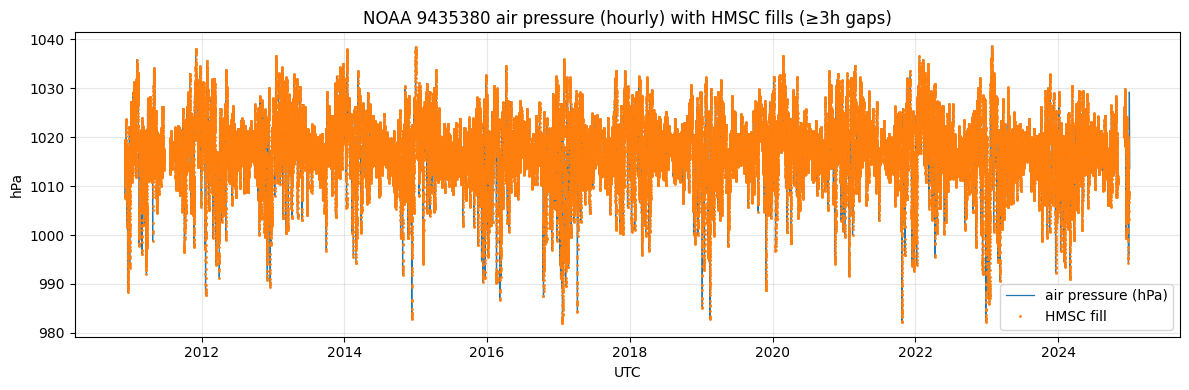

In [21]:
# ---------------- Config ----------------
NOAA_BEGIN_DATE = "20080101"
NOAA_END_DATE   = "20250101"
NOAA_STATION    = "9435380"
NOAA_CHUNK_DAYS = 365

session = requests.Session()

def _datestr(dt) -> str:
    return pd.Timestamp(dt).strftime("%Y%m%d")

# =============== NOAA (hourly air pressure, metric/hPa) ===============
def parse_noaa_airp_csv(txt: str) -> pd.DataFrame:
    df = pd.read_csv(io.StringIO(txt))
    if df.empty:
        return pd.DataFrame(columns=["time","airp_hpa"])
    # Normalize headers
    df.columns = [re.sub(r"\s+", " ", str(c).strip()) for c in df.columns]
    lc = [c.lower() for c in df.columns]

    # Time
    try:
        tcol = df.columns[lc.index("date time")]
    except ValueError:
        tcol = next((c for c in df.columns if any(k in c.lower() for k in ("date time","date_time","time","date","t"))),
                    df.columns[0])
    out = pd.DataFrame()
    out["time"] = pd.to_datetime(df[tcol], errors="coerce", utc=True).dt.tz_localize(None)

    # Air pressure column (NOAA usually labels as "Air Pressure" or "air_pressure")
    cand = [c for c in df.columns if ("air" in c.lower() and "press" in c.lower()) or (c.lower()=="air_pressure")]
    if not cand:
        # Fallback: pick the widest numeric column
        nums = [c for c in df.columns if c != tcol]
        cand = nums
    # choose the candidate with most finite numbers
    best, nbest = None, -1
    for c in cand:
        v = pd.to_numeric(df[c], errors="coerce")
        cnt = np.isfinite(v).sum()
        if cnt > nbest:
            best, nbest = c, cnt
    airp = pd.to_numeric(df[best], errors="coerce") if best else np.nan

    # NOAA returns metric → hPa already
    out["airp_hpa"] = airp
    # QC plausible bounds (sea-level ~ 900–1070 hPa)
    out.loc[(out["airp_hpa"] < 850) | (out["airp_hpa"] > 1100), "airp_hpa"] = np.nan

    return (out.dropna(subset=["time"])
               .sort_values("time")
               .drop_duplicates("time")
               .reset_index(drop=True))

def fetch_noaa_air_pressure(begin_date: str, end_date: str, station: str,
                            days_per_chunk: int = 365) -> pd.DataFrame:
    start = pd.to_datetime(begin_date, format="%Y%m%d")
    end   = pd.to_datetime(end_date,   format="%Y%m%d")
    frames, cur = [], start
    while cur <= end:
        chunk_end = min(end, cur + pd.Timedelta(days=days_per_chunk-1))
        url = ("https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
               f"?begin_date={_datestr(cur)}&end_date={_datestr(chunk_end)}"
               f"&station={station}&product=air_pressure&time_zone=gmt&interval=h&units=metric"
               "&application=DataAPI_Sample&format=csv")
        try:
            r = session.get(url, timeout=90)
            if r.ok and r.content:
                dfc = parse_noaa_airp_csv(r.content.decode("utf-8","ignore"))
                if not dfc.empty: frames.append(dfc)
        except Exception:
            pass
        cur = chunk_end + pd.Timedelta(days=1)
    if not frames:
        return pd.DataFrame(columns=["time","airp_hpa"])
    return (pd.concat(frames, ignore_index=True)
              .sort_values("time")
              .drop_duplicates("time")
              .reset_index(drop=True))

# ================= HMSC (5-min .dat → hourly hPa) =================
HMSC_BASE = "http://weather.hmsc.oregonstate.edu/weather/weatherproject/archive/{year}/HMSC_{year}{mm:02d}.dat"
INHG_TO_HPA = 33.8638866667  # inches Hg → hPa

def parse_hmsc_month_bp(txt: str, year: int, month: int) -> pd.DataFrame:
    """Extract TIMESTAMP (local PT) and AvgBP (inches) → UTC hPa; keep target month only."""
    rows = []
    for ln in txt.splitlines():
        s = ln.strip()
        if not s or s.startswith('"TOA5"') or s.startswith('"TIMESTAMP"') or s.startswith('"TS"') or s.startswith('"",'):
            continue
        parts = [p.strip().strip('"') for p in s.split(",")]
        if len(parts) < 11:
            continue
        ts = parts[0]       # "YYYY-MM-DD HH:MM:SS" (local PT)
        avgBP_in = parts[10]  # "AvgBP" column per header example (Inch)
        try:
            t_local = pd.to_datetime(ts, errors="coerce")
            if pd.isna(t_local):
                continue
            t_local = t_local.tz_localize("America/Los_Angeles", nonexistent="NaT", ambiguous="NaT")
            t_utc   = t_local.tz_convert("UTC").tz_localize(None)
        except Exception:
            continue
        try:
            bp_in = float(avgBP_in)
        except:
            bp_in = np.nan
        if not (25 <= bp_in <= 32):  # plausible inches Hg range
            bp_in = np.nan
        rows.append((t_utc, bp_in))
    if not rows:
        return pd.DataFrame(columns=["time","airp_hpa"])
    df = pd.DataFrame(rows, columns=["time","bp_in"])
    df["airp_hpa"] = df["bp_in"] * INHG_TO_HPA
    df = (df.drop(columns=["bp_in"])
            .dropna(subset=["time"])
            .sort_values("time")
            .drop_duplicates("time")
            .reset_index(drop=True))
    return df[(df["time"].dt.year==year) & (df["time"].dt.month==month)]

def fetch_hmsc_bp(begin_date: str, end_date: str) -> pd.DataFrame:
    """Fetch all months, parse AvgBP → hPa; return 5-min-ish records."""
    start = pd.to_datetime(begin_date, format="%Y%m%d")
    end   = pd.to_datetime(end_date,   format="%Y%m%d")
    frames=[]
    for year in range(start.year, end.year+1):
        m0 = 1 if year > start.year else start.month
        m1 = 12 if year < end.year   else end.month
        for mm in range(m0, m1+1):
            url = HMSC_BASE.format(year=year, mm=mm)
            try:
                r = session.get(url, timeout=60)
                if r.status_code==200 and r.content:
                    dfm = parse_hmsc_month_bp(r.content.decode("utf-8","ignore"), year, mm)
                    if not dfm.empty:
                        frames.append(dfm)
            except Exception:
                pass
    if not frames:
        return pd.DataFrame(columns=["time","airp_hpa"])
    return (pd.concat(frames, ignore_index=True)
              .sort_values("time")
              .drop_duplicates("time")
              .reset_index(drop=True))

def hourly_mean(df_in: pd.DataFrame, value_col: str) -> pd.DataFrame:
    """Average to exact top-of-hour UTC timestamps."""
    if df_in.empty:
        return pd.DataFrame(columns=["time", value_col])
    df = (df_in.dropna(subset=["time"])
                .sort_values("time")
                .set_index("time")[[value_col]]
                .resample("1h").mean()
                .reset_index())
    return df

# =================== Merge (fill NOAA ≥3h gaps with HMSC) ===================
def merge_noaa_hmsc_airp(noaa_hr: pd.DataFrame, hmsc_hr: pd.DataFrame) -> pd.DataFrame:
    if noaa_hr.empty and hmsc_hr.empty:
        return pd.DataFrame(columns=["time","airp_hpa","source"])

    t_min = min(noaa_hr["time"].min() if not noaa_hr.empty else hmsc_hr["time"].min(),
                hmsc_hr["time"].min() if not hmsc_hr.empty else noaa_hr["time"].min())
    t_max = max(noaa_hr["time"].max() if not noaa_hr.empty else hmsc_hr["time"].max(),
                hmsc_hr["time"].max() if not hmsc_hr.empty else noaa_hr["time"].max())
    grid = pd.date_range(t_min.floor("1h"), t_max.ceil("1h"), freq="1h")

    N = (noaa_hr.set_index("time").reindex(grid).rename_axis("time").reset_index())
    N = N.rename(columns={"airp_hpa":"airp_noaa"})
    H = (hmsc_hr.set_index("time").reindex(grid).rename_axis("time").reset_index())
    H = H.rename(columns={"airp_hpa":"airp_hmsc"})

    out = pd.DataFrame({"time": grid})
    out["airp_hpa"] = pd.to_numeric(N["airp_noaa"], errors="coerce")
    out["source"]   = np.where(out["airp_hpa"].notna(), "NOAA", "NaN")

    # Identify consecutive NOAA-missing runs (≥3h)
    miss = out["airp_hpa"].isna()
    if miss.any():
        grp = (miss != miss.shift()).cumsum()
        for _, idx in out.groupby(grp).groups.items():
            idx = list(idx)
            if miss.iloc[idx[0]] and len(idx) >= 3:
                h_fill = pd.to_numeric(H.loc[idx, "airp_hmsc"], errors="coerce").to_numpy(dtype=float)
                take   = np.isfinite(h_fill)
                if take.any():
                    cur = out.loc[idx, "airp_hpa"].to_numpy(dtype=float)
                    src = out.loc[idx, "source"].to_numpy(object)
                    cur[take] = h_fill[take]
                    src[take] = "HMSC"
                    out.loc[idx, "airp_hpa"] = cur
                    out.loc[idx, "source"]   = src

    # Final QC bounds
    out.loc[(out["airp_hpa"] < 850) | (out["airp_hpa"] > 1100), "airp_hpa"] = np.nan
    return out.reset_index(drop=True)

# =========================== Driver ===========================
noaa_airp_raw = fetch_noaa_air_pressure(NOAA_BEGIN_DATE, NOAA_END_DATE, NOAA_STATION, days_per_chunk=NOAA_CHUNK_DAYS)
noaa_airp_hr  = hourly_mean(noaa_airp_raw, "airp_hpa")   # already hourly; keeps consistent pipeline
hmsc_airp_raw = fetch_hmsc_bp(NOAA_BEGIN_DATE, NOAA_END_DATE)   # 5-min-ish
hmsc_airp_hr  = hourly_mean(hmsc_airp_raw, "airp_hpa")          # hourly mean

df_airp = merge_noaa_hmsc_airp(noaa_airp_hr, hmsc_airp_hr)

print("NOAA air pressure (raw) coverage:",
      (noaa_airp_raw["time"].min() if len(noaa_airp_raw) else None), "→",
      (noaa_airp_raw["time"].max() if len(noaa_airp_raw) else None), f"(n={len(noaa_airp_raw):,})")
print("HMSC air pressure (5-min) coverage:",
      (hmsc_airp_raw["time"].min() if len(hmsc_airp_raw) else None), "→",
      (hmsc_airp_raw["time"].max() if len(hmsc_airp_raw) else None), f"(n={len(hmsc_airp_raw):,})")
print("Merged hourly air pressure coverage:",
      (df_airp["time"].min() if len(df_airp) else None), "→",
      (df_airp["time"].max() if len(df_airp) else None), f"(n={len(df_airp):,})")
print("Source counts:", df_airp["source"].value_counts(dropna=False).to_dict())

# expects df_airp from your merge step with columns ["time","airp_hpa"]
assert {"time","airp_hpa"}.issubset(df_airp.columns)

# --- 6-min grid (align to your global grid if present) ---
if "t_grid" in globals():
    t6 = pd.DatetimeIndex(pd.to_datetime(t_grid))
else:
    t0 = pd.to_datetime(df_airp["time"].min()).floor("6min")
    t1 = pd.to_datetime(df_airp["time"].max()).ceil("6min")
    t6 = pd.date_range(t0, t1, freq="6min")

# --- Interpolate to 6-min; do NOT bridge gaps > 3h (30 steps) ---
s = pd.Series(df_airp["airp_hpa"].astype(float).to_numpy(),
              index=pd.to_datetime(df_airp["time"]))
u = s.reindex(pd.to_datetime(sorted(set(s.index).union(set(t6)))))
u = u.interpolate(method="time", limit=30, limit_direction="both", limit_area="inside")
airp_6 = u.reindex(t6)

# --- 4h high-pass (signal − 4h moving mean), then 1h moving variance ---
lp4h = airp_6.rolling("4H", center=True, min_periods=10).mean()
hp4h = airp_6 - lp4h
var1h = hp4h.rolling("1H", center=True, min_periods=6).var(ddof=0)

# --- Final minimal DataFrame for your model matrix ---
df_air_forcing = pd.DataFrame({
    "time": t6,
    "airp_hpa_6min": airp_6.to_numpy(),           # barometric pressure (forcing level)
    "airp_var1h":    var1h.to_numpy(),            # variance of HP(4h) pressure (forcing variability)
})


# ---------------- Quick sanity plot (optional) ----------------
try:
    import matplotlib.pyplot as plt
    t   = pd.to_datetime(df_airp["time"], utc=True)
    ap  = df_airp["airp_hpa"]
    src = df_airp["source"]
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(t, ap, lw=0.9, color="tab:blue", label="air pressure (hPa)")
    m_hmsc = src.eq("HMSC") & ap.notna()
    ax.plot(t[m_hmsc], ap[m_hmsc], ".", ms=2, color="tab:orange", label="HMSC fill")
    ax.set_ylabel("hPa"); ax.set_xlabel("UTC")
    ax.grid(True, alpha=0.3); ax.legend(); ax.set_title("NOAA 9435380 air pressure (hourly) with HMSC fills (≥3h gaps)")
    plt.tight_layout(); plt.show()
except Exception:
    pass



SWDEN (uniform df) coverage: 2008-03-05 17:00:00 → 2008-12-31 23:00:00 (n=7,051)


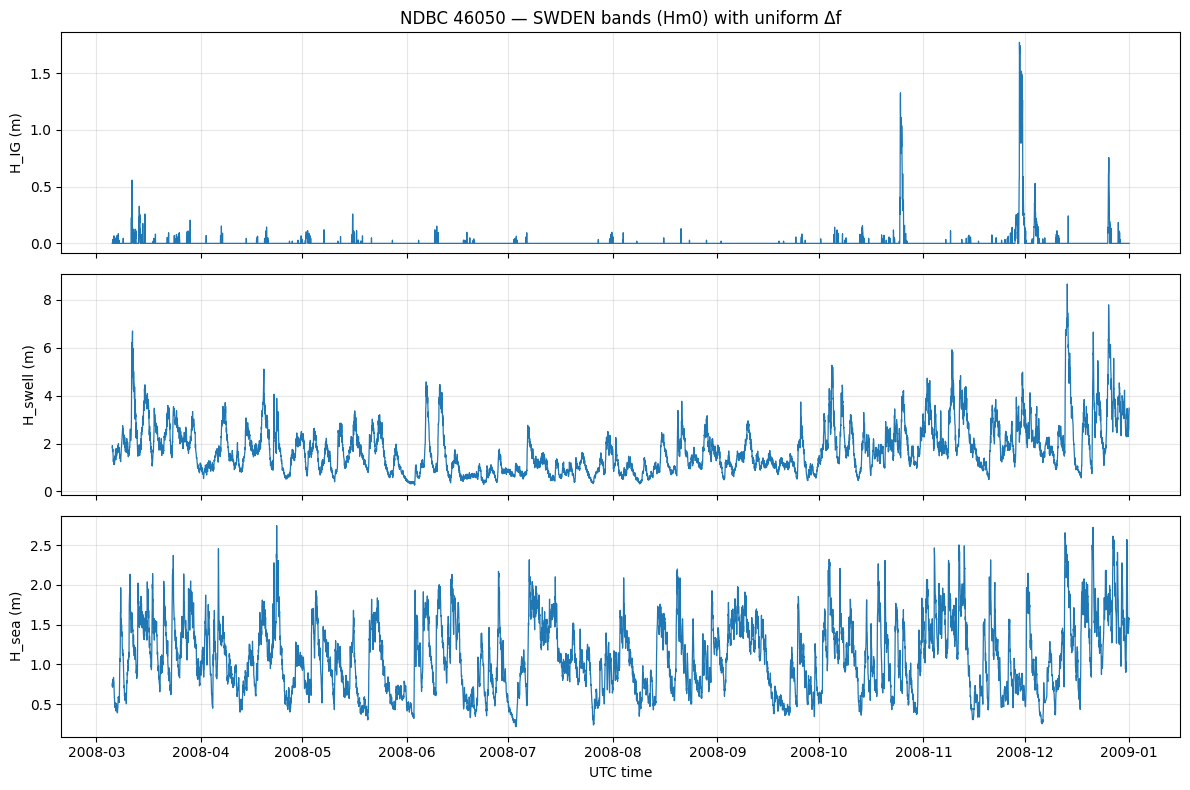

In [4]:
session = requests.Session()
BUOY  = "46050"
YEARS = list(range(2008, 2026))  # adjust as needed

STDMET_URL = "https://www.ndbc.noaa.gov/view_text_file.php?filename={buoy}h{year}.txt.gz&dir=data/historical/stdmet/"

def _ndbc_to_float(tok:str) -> float:
    s = str(tok).strip()
    if s == "" or s.upper() == "MM": return np.nan
    # treat 99.00, 999, 999.0, etc. as missing
    if re.fullmatch(r"-?9+(\.0+)?", s): return np.nan
    try: return float(s)
    except: return np.nan

def fetch_stdmet_text(year:int, buoy:str)->str|None:
    url = STDMET_URL.format(buoy=buoy, year=year)
    try:
        r = session.get(url, timeout=45)
        if r.ok and r.text and "Page Not Found" not in r.text:
            return r.text
    except: pass
    return None

def parse_stdmet_headered(txt:str)->pd.DataFrame:
    """
    Robust parse that handles:
      - repeated '#YY ...' header lines
      - 10-min vs hourly cadence (keeps native)
      - '99.00'/'999'/'MM' sentinels -> NaN
    Returns columns: time, Hs, DPD, APD, MWD
    """
    if not txt:
        return pd.DataFrame(columns=["time","Hs","DPD","APD","MWD"])

    lines = [ln.rstrip("\n") for ln in txt.splitlines() if ln.strip()]
    name2idx = None
    out = []

    for ln in lines:
        if ln.lstrip().startswith("#YY"):          # new header block
            hdr_tokens = re.split(r"\s+", ln.lstrip("#").strip())
            # build index map for the columns we need
            name2idx = {name:i for i,name in enumerate(hdr_tokens)}
            continue
        if ln.lstrip().startswith("#"):
            continue
        if name2idx is None:
            # haven’t seen a header yet; skip
            continue

        parts = re.split(r"\s+", ln.strip())
        # require at least YY MM DD hh
        if len(parts) < 4:
            continue

        try:
            YY = int(parts[name2idx.get("YY", 0)])
            MM = int(parts[name2idx.get("MM", 1)])
            DD = int(parts[name2idx.get("DD", 2)])
            hh = int(parts[name2idx.get("hh", 3)])
            mi = int(parts[name2idx["mm"]]) if "mm" in name2idx and name2idx["mm"] < len(parts) else 0
            yyyy = 2000+YY if YY < 100 else YY
            ts = pd.Timestamp(year=yyyy, month=MM, day=DD, hour=hh, minute=mi, tz="UTC").tz_localize(None)
        except Exception:
            continue

        def g(col):
            idx = name2idx.get(col, None)
            if idx is None or idx >= len(parts): return np.nan
            return _ndbc_to_float(parts[idx])

        Hs  = g("WVHT")  # significant wave height (m)
        DPD = g("DPD")   # dominant period (s)
        APD = g("APD")   # average period (s)
        MWD = g("MWD")   # mean wave direction (deg)

        # soft sanity (don’t over-filter)
        if np.isfinite(Hs) and Hs > 35:  Hs  = np.nan
        if np.isfinite(DPD) and DPD > 50: DPD = np.nan
        if np.isfinite(APD) and APD > 50: APD = np.nan
        if np.isfinite(MWD) and not (0 <= MWD <= 360): MWD = np.nan

        out.append((ts, Hs, DPD, APD, MWD))

    if not out:
        return pd.DataFrame(columns=["time","Hs","DPD","APD","MWD"])

    df = (pd.DataFrame(out, columns=["time","Hs","DPD","APD","MWD"])
            .dropna(subset=["time"])
            .sort_values("time")
            .drop_duplicates("time")
            .reset_index(drop=True))
    return df

def build_stdmet_all(years:list[int], buoy:str)->pd.DataFrame:
    frames=[]
    for y in years:
        txt = fetch_stdmet_text(y, buoy)
        if not txt:
            continue
        d = parse_stdmet_headered(txt)
        if not d.empty:
            frames.append(d)
    if not frames:
        return pd.DataFrame(columns=["time","Hs","DPD","APD","MWD"])
    return (pd.concat(frames, ignore_index=True)
              .sort_values("time")
              .drop_duplicates("time")
              .reset_index(drop=True))

# -------- run + quick verification plots --------
df_stdmet = build_stdmet_all(YEARS, BUOY)

# --- Diagnostics + robust plotting for stdmet (no averaging of cadence) ---
assert not df_stdmet.empty, "No stdmet data parsed."

# 1) Coerce numeric and sort by time
dfS = df_stdmet.copy()
for c in ["Hs","DPD","APD","MWD"]:
    if c in dfS.columns:
        dfS[c] = pd.to_numeric(dfS[c], errors="coerce")
dfS = dfS.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

# 2) Valid counts per year + cadence check
yr = dfS["time"].dt.year
print("Valid by year (Hs/DPD/APD/MWD) + median Δt:")
for y in sorted(yr.unique()):
    sub = dfS.loc[yr==y]
    dt_med = (sub["time"].diff().median() if len(sub)>1 else pd.NaT)
    print(f"  {y}: Hs={np.isfinite(sub['Hs']).sum():5d}, "
          f"DPD={np.isfinite(sub['DPD']).sum():5d}, "
          f"APD={np.isfinite(sub['APD']).sum():5d}, "
          f"MWD={np.isfinite(sub['MWD']).sum():5d}, "
          f"Δt≈{dt_med}")

# 3) Finite-only masks
mHs  = np.isfinite(dfS["Hs"])
mDPD = np.isfinite(dfS["DPD"])
mAPD = np.isfinite(dfS["APD"])
mMWD = np.isfinite(dfS["MWD"])

# 4) Rolling medians (3 hours) to make structure visible across gaps
#    note: we keep native cadence; this is just a visual smoother
def roll_med(s: pd.Series, win="3H"):
    v = s.copy()
    v.index = dfS["time"]
    return v.rolling(win, min_periods=1).median().reindex(dfS["time"]).to_numpy()

Hs_rm  = roll_med(dfS["Hs"])
DPD_rm = roll_med(dfS["DPD"])
APD_rm = roll_med(dfS["APD"])
MWD_rm = roll_med(dfS["MWD"])

# 5) Percentile-based y-lims (avoid extreme outliers hiding the cloud)
def safe_ylim(vals, lo=0, hi=99):
    v = pd.to_numeric(vals, errors="coerce")
    top = np.nanpercentile(v, hi) if np.isfinite(v).any() else np.nan
    if not np.isfinite(top) or top <= 0: top = 1.0
    return (0.0 if lo==0 else np.nanpercentile(v, lo), top * 1.1)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(4,1, figsize=(13,9), sharex=True)

# Hs
axs[0].scatter(dfS["time"][mHs], dfS["Hs"][mHs], s=3, alpha=0.5, label="Hs (finite)")
axs[0].plot(dfS["time"], Hs_rm, lw=1.0, label="Hs (3h median)")
axs[0].set_ylabel("Hs (m)"); axs[0].grid(True, alpha=0.3)
yl = safe_ylim(dfS["Hs"]); axs[0].set_ylim(yl)
axs[0].legend(loc="upper right")

# DPD
axs[1].scatter(dfS["time"][mDPD], dfS["DPD"][mDPD], s=3, alpha=0.5, label="DPD (finite)")
axs[1].plot(dfS["time"], DPD_rm, lw=1.0, label="DPD (3h median)")
axs[1].set_ylabel("DPD (s)"); axs[1].grid(True, alpha=0.3)
yl = safe_ylim(dfS["DPD"]); axs[1].set_ylim(yl)
axs[1].legend(loc="upper right")

# APD
axs[2].scatter(dfS["time"][mAPD], dfS["APD"][mAPD], s=3, alpha=0.5, label="APD (finite)")
axs[2].plot(dfS["time"], APD_rm, lw=1.0, label="APD (3h median)")
axs[2].set_ylabel("APD (s)"); axs[2].grid(True, alpha=0.3)
yl = safe_ylim(dfS["APD"]); axs[2].set_ylim(yl)
axs[2].legend(loc="upper right")

# MWD
axs[3].scatter(dfS["time"][mMWD], dfS["MWD"][mMWD], s=3, alpha=0.4, label="MWD (finite)")
axs[3].plot(dfS["time"], MWD_rm, lw=0.8, alpha=0.8, label="MWD (3h median)")
axs[3].set_ylabel("MWD (°)"); axs[3].grid(True, alpha=0.3)
axs[3].set_xlabel("UTC time")
axs[3].set_ylim(0, 360); axs[3].legend(loc="upper right")

fig.suptitle(f"NDBC {BUOY} stdmet — native cadence (hourly → 10-min post-2017)")
plt.tight_layout(); plt.show()




# ---- settings ----
BUOY  = "46050"
YEARS = list(range(2008, 2026))

try:
    session
except NameError:
    session = requests.Session()

SWDEN_URL = "https://www.ndbc.noaa.gov/view_text_file.php?filename={buoy}w{year}.txt.gz&dir=data/historical/swden/"

def _to_float(tok:str)->float:
    s = str(tok).strip()
    if s == "" or s.upper()=="MM": return np.nan
    try: return float(s)
    except: return np.nan

def _is_num(tok:str)->bool:
    try: float(tok); return True
    except: return False

def fetch_swden_year_text(year:int, buoy:str)->str|None:
    url = SWDEN_URL.format(buoy=buoy, year=year)
    try:
        r = session.get(url, timeout=45)
        if r.ok and r.text and "Page Not Found" not in r.text:
            return r.text
    except: pass
    return None

def _uniform_grid(freqs: np.ndarray, fmin=0.02, fmax=0.485) -> tuple[np.ndarray, float]:
    """Even df from fmin..fmax using smallest native Δf (rounded)."""
    f = np.sort(np.unique(freqs[np.isfinite(freqs)]))
    if f.size < 2:
        return np.array([fmin, fmax]), (fmax-fmin)
    d = np.diff(f)
    df_native = np.min(d[d>0])
    df = float(np.round(df_native, 6))
    n = int(np.floor((fmax - fmin)/df + 1e-9)) + 1
    fu = fmin + df*np.arange(n, dtype=float)
    for edge in (0.05, 0.14, 0.30):
        if fu[0] <= edge <= fu[-1]:
            k = int(round((edge - fmin)/df))
            fu[k] = edge
    return fu, df

def _hm0_from_bands(fu: np.ndarray, Su: np.ndarray, df: float) -> tuple[float,float,float]:
    mask_IG    = (fu >= 0.02) & (fu <  0.05)
    mask_swell = (fu >= 0.05) & (fu <= 0.14)
    mask_sea   = (fu >  0.14) & (fu <= 0.30)

    def band_H(mask):
        if not np.any(mask): return np.nan
        m0 = np.nansum(Su[mask]) * df
        if not np.isfinite(m0) or m0 < 0: return np.nan
        return 4.0*np.sqrt(m0)

    return band_H(mask_IG), band_H(mask_swell), band_H(mask_sea)

def parse_swden_uniform(txt:str) -> pd.DataFrame:
    """
    Parse one SWDEN file with robust header detection:
      - Handles 2008-style: '#YY MM DD hh mm .0200 .0325 ...' (freqs on SAME line)
      - Or classic: freq line is the next non-comment after '#YY ...'
      - Or first non-comment line starting with '.'
      - Then builds uniform grid (0.02..0.485 Hz; Δf = min native Δf), interpolates spectra, integrates bands.
    Returns: [time, H_IG, H_swell, H_sea]
    """
    if not txt:
        return pd.DataFrame(columns=["time","H_IG","H_swell","H_sea"])

    lines = [ln.strip() for ln in txt.splitlines() if ln.strip()]

    # --- locate & parse frequency header (robust) ---
    freqs = None
    data_start = None

    # (A) Prefer '#YY ...' header if present (works for 2008 when freqs are on same line)
    hdr_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith("#YY"):
            hdr_idx = i
    if hdr_idx is not None:
        hdr_toks = re.split(r"\s+", lines[hdr_idx].strip())
        freq_candidates = hdr_toks[5:] if len(hdr_toks) > 5 else []
        freq_nums = [t for t in freq_candidates if _is_num(t)]
        if len(freq_nums) >= 10:
            freqs = np.array([_to_float(t) for t in freq_nums], dtype=float)
            freqs = freqs[np.isfinite(freqs)]
            j = hdr_idx + 1
            while j < len(lines) and lines[j].startswith("#"):
                j += 1
            data_start = j

    # (B) Otherwise: first non-comment line whose first token starts with '.'
    if freqs is None or freqs.size == 0:
        freq_idx = None
        for i, ln in enumerate(lines):
            if ln.startswith("#"):
                continue
            toks = re.split(r"\s+", ln)
            if toks and toks[0].startswith("."):
                freq_idx = i
                break
        if freq_idx is not None:
            freq_tokens = [t for t in re.split(r"\s+", lines[freq_idx]) if _is_num(t)]
            freqs = np.array([_to_float(t) for t in freq_tokens], dtype=float)
            freqs = freqs[np.isfinite(freqs)]
            data_start = freq_idx + 1

    # (C) Last-resort: '#YY' existed, but freqs are on the NEXT non-comment line
    if (freqs is None or freqs.size == 0) and hdr_idx is not None:
        j = hdr_idx + 1
        while j < len(lines) and lines[j].startswith("#"):
            j += 1
        if j < len(lines):
            freq_tokens = [t for t in re.split(r"\s+", lines[j]) if _is_num(t)]
            if len(freq_tokens) >= 10:
                freqs = np.array([_to_float(t) for t in freq_tokens], dtype=float)
                freqs = freqs[np.isfinite(freqs)]
                data_start = j + 1

    if freqs is None or freqs.size == 0 or data_start is None:
        return pd.DataFrame(columns=["time","H_IG","H_swell","H_sea"])

    # --- build uniform grid once per file ---
    fu, df = _uniform_grid(freqs, 0.02, 0.485)

    # --- spectra loop ---
    rows = []
    for ln in lines[data_start:]:
        if ln.startswith("#"):
            continue
        toks = [t for t in re.split(r"\s+", ln) if t]
        if len(toks) < 4:
            continue
        # time fields: YY MM DD hh [mm] then spectrum
        try:
            y = int(toks[0]); mo=int(toks[1]); dy=int(toks[2]); hh=int(toks[3])
            if len(toks) >= 5 and _is_num(toks[4]):
                mm = int(float(toks[4])); off = 5
            else:
                mm = 0; off = 4
            yy = 2000+y if y < 100 else y
            ts = pd.Timestamp(year=yy, month=mo, day=dy, hour=hh, minute=mm, tz="UTC").tz_localize(None)
        except Exception:
            continue

        spec_vals = np.array([_to_float(v) for v in toks[off:]], dtype=float)

        # align to header length (pad/truncate)
        if spec_vals.size != freqs.size:
            if spec_vals.size < freqs.size:
                spec_vals = np.pad(spec_vals, (0, freqs.size - spec_vals.size), constant_values=np.nan)
            else:
                spec_vals = spec_vals[:freqs.size]

        # interpolate onto uniform grid; energy outside native range = 0
        Su = np.interp(fu, freqs, np.nan_to_num(spec_vals, nan=0.0), left=0.0, right=0.0)
        H_IG, H_swell, H_sea = _hm0_from_bands(fu, Su, df)

        # If a band is truly zero everywhere, keep 0.0 (not NaN)
        rows.append((
            ts,
            0.0 if np.all(Su[(fu>=0.02)&(fu<0.05)]==0)  else (H_IG    if np.isfinite(H_IG)    else np.nan),
            0.0 if np.all(Su[(fu>=0.05)&(fu<=0.14)]==0) else (H_swell if np.isfinite(H_swell) else np.nan),
            0.0 if np.all(Su[(fu>0.14)&(fu<=0.30)]==0)  else (H_sea   if np.isfinite(H_sea)   else np.nan),
        ))

    if not rows:
        return pd.DataFrame(columns=["time","H_IG","H_swell","H_sea"])

    return (pd.DataFrame(rows, columns=["time","H_IG","H_swell","H_sea"])
              .sort_values("time").drop_duplicates("time").reset_index(drop=True))

# ---- build across years ----
frames = []
for y in YEARS:
    txt = fetch_swden_year_text(y, BUOY)
    if not txt:
        continue
    dfy = parse_swden_uniform(txt)
    if not dfy.empty:
        frames.append(dfy)

df_swden_uniform = (pd.concat(frames, ignore_index=True)
                      .sort_values("time").drop_duplicates("time").reset_index(drop=True)
                   ) if frames else pd.DataFrame(columns=["time","H_IG","H_swell","H_sea"])

print("SWDEN (uniform df) coverage:",
      (df_swden_uniform["time"].min() if not df_swden_uniform.empty else None), "→",
      (df_swden_uniform["time"].max() if not df_swden_uniform.empty else None),
      f"(n={len(df_swden_uniform):,})")

# ---- plot bands (native cadence; no averaging) ----
if not df_swden_uniform.empty:
    fig, axs = plt.subplots(3,1, figsize=(12,8), sharex=True)
    axs[0].plot(df_swden_uniform["time"], df_swden_uniform["H_IG"], lw=0.9)
    axs[0].set_ylabel("H_IG (m)"); axs[0].grid(True, alpha=0.3)
    axs[0].set_title(f"NDBC {BUOY} — SWDEN bands (Hm0) with uniform Δf")

    axs[1].plot(df_swden_uniform["time"], df_swden_uniform["H_swell"], lw=0.9)
    axs[1].set_ylabel("H_swell (m)"); axs[1].grid(True, alpha=0.3)

    axs[2].plot(df_swden_uniform["time"], df_swden_uniform["H_sea"], lw=0.9)
    axs[2].set_ylabel("H_sea (m)"); axs[2].set_xlabel("UTC time"); axs[2].grid(True, alpha=0.3)

    plt.tight_layout(); plt.show()
else:
    print("No SWDEN data parsed.")


SWDEN header: 47 freqs, range 0.0200–0.4850 Hz; data_start line idx = 1
First data line preview: 2008 03 05 17 00   0.00   0.00   0.00   0.00   0.00   0.00   0.17   0.78   2.15   5.81   6.17   2.41   2.12   3.04   3.2


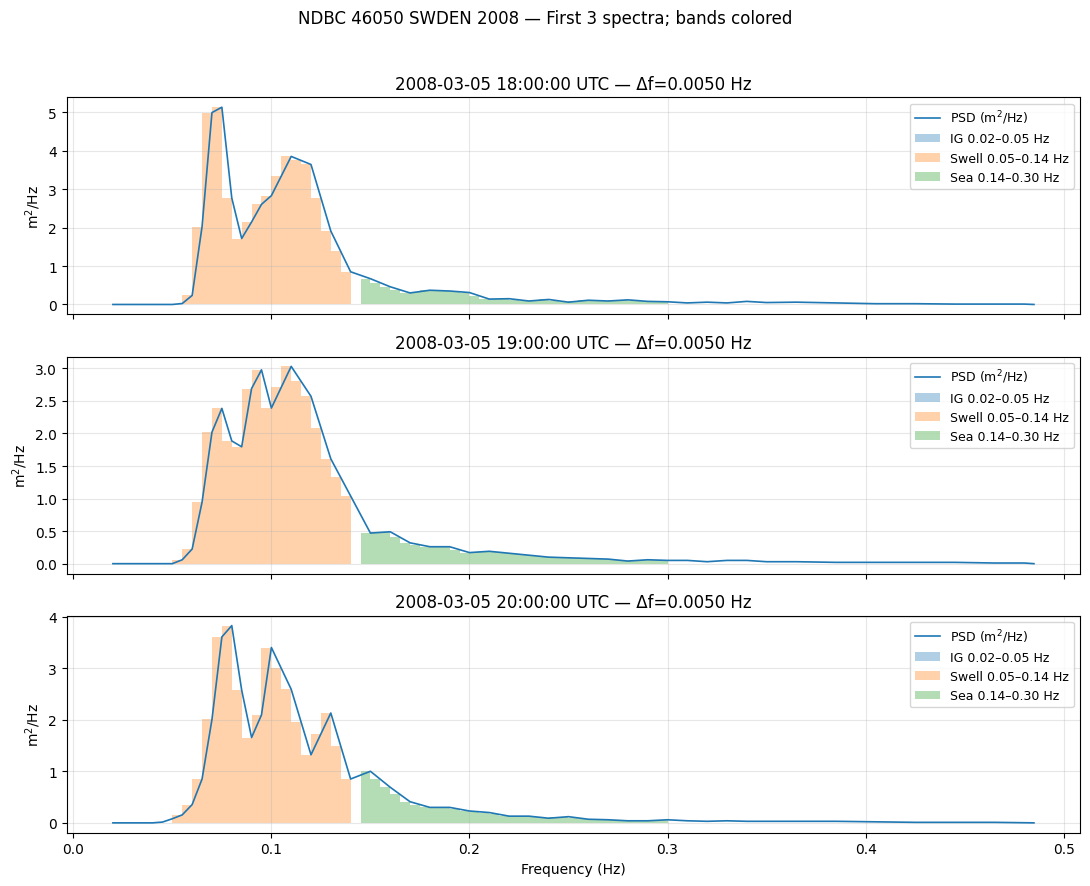

Times (UTC):
  2008-03-05 18:00:00
  2008-03-05 19:00:00
  2008-03-05 20:00:00

H_IG  (m): [0.0, 0.0, 0.034641016151377525]
H_swell (m): [1.9174636024359542, 1.6624479941740535, 1.688865496914028]
H_sea  (m): [0.7688953114696435, 0.7141428428542851, 0.8067217612039482]


In [3]:
### TESTING TO VERIFY
# # =========================
# # NDBC 46050 SWDEN (2008) — first 3 spectra
# # Plot PSDs with band coloring + print H_IG, H_swell, H_sea per time
# # =========================
# import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, requests

# BUOY  = "46050"
# YEAR  = 2008
# URL   = f"https://www.ndbc.noaa.gov/view_text_file.php?filename={BUOY}w{YEAR}.txt.gz&dir=data/historical/swden/"

# # ---------- helpers ----------
# def _to_float(tok:str)->float:
#     s = str(tok).strip()
#     if s == "" or s.upper()=="MM": return np.nan
#     try: return float(s)
#     except: return np.nan

# def _is_num(tok:str)->bool:
#     try: float(tok); return True
#     except: return False

# def _uniform_grid(freqs: np.ndarray, fmin=0.02, fmax=0.485):
#     """Even df grid from fmin..fmax using smallest positive native Δf."""
#     f = np.sort(np.unique(freqs[np.isfinite(freqs)]))
#     if f.size < 2:
#         df = (fmax - fmin) if f.size==1 else 0.005
#         n  = int(np.floor((fmax - fmin)/df + 1e-9)) + 1
#         return fmin + df*np.arange(n), df
#     d = np.diff(f)
#     df_native = np.min(d[d > 0])
#     df = float(np.round(df_native, 6))
#     n  = int(np.floor((fmax - fmin)/df + 1e-9)) + 1
#     fu = fmin + df*np.arange(n, dtype=float)
#     # snap band edges exactly if inside range
#     for edge in (0.05, 0.14, 0.30):
#         if fu[0] <= edge <= fu[-1]:
#             k = int(round((edge - fmin)/df))
#             fu[k] = edge
#     return fu, df

# def _hm0_from_bands(fu: np.ndarray, Su: np.ndarray, df: float):
#     """Return H_IG, H_swell, H_sea for uniform grid."""
#     mask_IG    = (fu >= 0.02) & (fu <  0.05)
#     mask_swell = (fu >= 0.05) & (fu <= 0.14)
#     mask_sea   = (fu >  0.14) & (fu <= 0.30)

#     def H(mask):
#         if not np.any(mask): return np.nan
#         m0 = np.nansum(Su[mask]) * df
#         return 4.0*np.sqrt(m0) if np.isfinite(m0) and m0 >= 0 else np.nan

#     return H(mask_IG), H(mask_swell), H(mask_sea)

# # ---------- fetch & parse ----------
# session = requests.Session()
# r = session.get(URL, timeout=45)
# r.raise_for_status()
# txt = r.text

# lines = [ln.strip() for ln in txt.splitlines() if ln.strip()]

# # --- locate & parse frequency header (robust to '#YY ... .0200 .0325 ...' on SAME line) ---
# freqs = None
# data_start = None

# # 1) Prefer a '#YY ...' header if present
# hdr_idx = None
# for i, ln in enumerate(lines):
#     if ln.startswith("#YY"):
#         hdr_idx = i

# if hdr_idx is not None:
#     hdr_toks = re.split(r"\s+", lines[hdr_idx].strip())
#     # '#YY','MM','DD','hh','mm', then the frequency tokens typically start
#     freq_candidates = hdr_toks[5:] if len(hdr_toks) > 5 else []
#     freq_nums = [t for t in freq_candidates if _is_num(t)]
#     if len(freq_nums) >= 10:
#         freqs = np.array([_to_float(t) for t in freq_nums], dtype=float)
#         freqs = freqs[np.isfinite(freqs)]
#         # data start = first non-comment line after header
#         j = hdr_idx + 1
#         while j < len(lines) and lines[j].startswith("#"):
#             j += 1
#         data_start = j

# # 2) Otherwise fall back to: first non-comment line whose first token starts with "."
# if freqs is None or freqs.size == 0:
#     freq_idx = None
#     for i, ln in enumerate(lines):
#         if ln.startswith("#"):
#             continue
#         toks = re.split(r"\s+", ln)
#         if toks and toks[0].startswith("."):
#             freq_idx = i
#             break
#     if freq_idx is not None:
#         freq_tokens = [t for t in re.split(r"\s+", lines[freq_idx]) if _is_num(t)]
#         freqs = np.array([_to_float(t) for t in freq_tokens], dtype=float)
#         freqs = freqs[np.isfinite(freqs)]
#         # data start = next line
#         data_start = freq_idx + 1

# # 3) Last-resort: if we saw '#YY' but no freqs on same line, try the next non-comment line as freqs
# if (freqs is None or freqs.size == 0) and hdr_idx is not None and data_start is not None:
#     freq_tokens = [t for t in re.split(r"\s+", lines[data_start]) if _is_num(t)]
#     freqs = np.array([_to_float(t) for t in freq_tokens], dtype=float)
#     freqs = freqs[np.isfinite(freqs)]
#     data_start = data_start + 1  # actual spectra start after that line

# # Validate
# if freqs is None or freqs.size == 0:
#     raise RuntimeError("Could not locate a valid frequency header in SWDEN file.")

# # Optional: quick diagnostics so you can see what got picked up
# try:
#     fmin, fmax = float(np.nanmin(freqs)), float(np.nanmax(freqs))
#     print(f"SWDEN header: {freqs.size} freqs, range {fmin:.4f}–{fmax:.4f} Hz; data_start line idx = {data_start}")
#     if data_start is not None and data_start < len(lines):
#         print("First data line preview:", lines[data_start][:120])
# except Exception:
#     pass


# # uniform grid setup (once, from header)
# fu, df = _uniform_grid(freqs, 0.02, 0.485)

# # collect first 3 spectra
# rows = []
# for ln in lines[freq_idx+1:]:
#     if ln.startswith("#"):
#         continue
#     toks = [t for t in re.split(r"\s+", ln) if t]
#     if len(toks) < 4:
#         continue
#     try:
#         y = int(toks[0]); mo=int(toks[1]); dy=int(toks[2]); hh=int(toks[3])
#         if len(toks) >= 5 and _is_num(toks[4]):
#             mm = int(float(toks[4])); off = 5
#         else:
#             mm = 0; off = 4
#         yy = 2000 + y if y < 100 else y
#         ts = pd.Timestamp(year=yy, month=mo, day=dy, hour=hh, minute=mm, tz="UTC").tz_localize(None)
#     except Exception:
#         continue

#     S = np.array([_to_float(v) for v in toks[off:]], dtype=float)
#     # align S length to header freqs
#     if S.size != freqs.size:
#         if S.size < freqs.size:
#             S = np.pad(S, (0, freqs.size - S.size), constant_values=np.nan)
#         else:
#             S = S[:freqs.size]

#     rows.append((ts, S))
#     if len(rows) == 3:
#         break

# if len(rows) == 0:
#     raise RuntimeError("No spectra found in file.")
# if len(rows) < 3:
#     print(f"Only found {len(rows)} spectra; proceeding with available.")

# # ---------- compute H per band + plot PSDs ----------
# times = []
# H_IG_list, H_swell_list, H_sea_list = [], [], []

# fig, axes = plt.subplots(len(rows), 1, figsize=(11, 9), sharex=True)
# if len(rows) == 1:
#     axes = [axes]

# for ax, (ts, S_native) in zip(axes, rows):
#     # interpolate onto uniform grid; outside native range -> 0
#     Su = np.interp(fu, freqs, np.nan_to_num(S_native, nan=0.0), left=0.0, right=0.0)

#     # compute H's
#     H_IG, H_swell, H_sea = _hm0_from_bands(fu, Su, df)
#     times.append(ts)
#     H_IG_list.append(0.0 if np.all(Su[(fu>=0.02)&(fu<0.05)] == 0) else H_IG)
#     H_swell_list.append(0.0 if np.all(Su[(fu>=0.05)&(fu<=0.14)] == 0) else H_swell)
#     H_sea_list.append(0.0 if np.all(Su[(fu>0.14)&(fu<=0.30)] == 0) else H_sea)

#     # masks
#     mask_IG    = (fu >= 0.02) & (fu <  0.05)
#     mask_swell = (fu >= 0.05) & (fu <= 0.14)
#     mask_sea   = (fu >  0.14) & (fu <= 0.30)

#     # base PSD
#     ax.plot(fu, Su, lw=1.2, label="PSD (m$^2$/Hz)")
#     # colored fills for bands
#     ax.fill_between(fu[mask_IG],    Su[mask_IG],    step="pre", alpha=0.35, label="IG 0.02–0.05 Hz")
#     ax.fill_between(fu[mask_swell], Su[mask_swell], step="pre", alpha=0.35, label="Swell 0.05–0.14 Hz")
#     ax.fill_between(fu[mask_sea],   Su[mask_sea],   step="pre", alpha=0.35, label="Sea 0.14–0.30 Hz")

#     ax.set_ylabel("m$^2$/Hz")
#     ax.set_title(f"{ts} UTC — Δf={df:.4f} Hz")
#     ax.grid(True, alpha=0.3)
#     ax.legend(loc="upper right", fontsize=9)

# axes[-1].set_xlabel("Frequency (Hz)")
# plt.suptitle(f"NDBC {BUOY} SWDEN {YEAR} — First {len(rows)} spectra; bands colored", y=0.98)
# plt.tight_layout(rect=[0,0,1,0.96])
# plt.show()

# # ---------- print results ----------
# print("Times (UTC):")
# for t in times: print(f"  {t}")

# print("\nH_IG  (m):",   [None if (x is np.nan or x is None) else float(x) for x in H_IG_list])
# print("H_swell (m):", [None if (x is np.nan or x is None) else float(x) for x in H_swell_list])
# print("H_sea  (m):",  [None if (x is np.nan or x is None) else float(x) for x in H_sea_list])


Fetched M≥7.0 events in Pacific 2008-01-01→2026-12-31: 219
Events painted into grid: 219 / 219


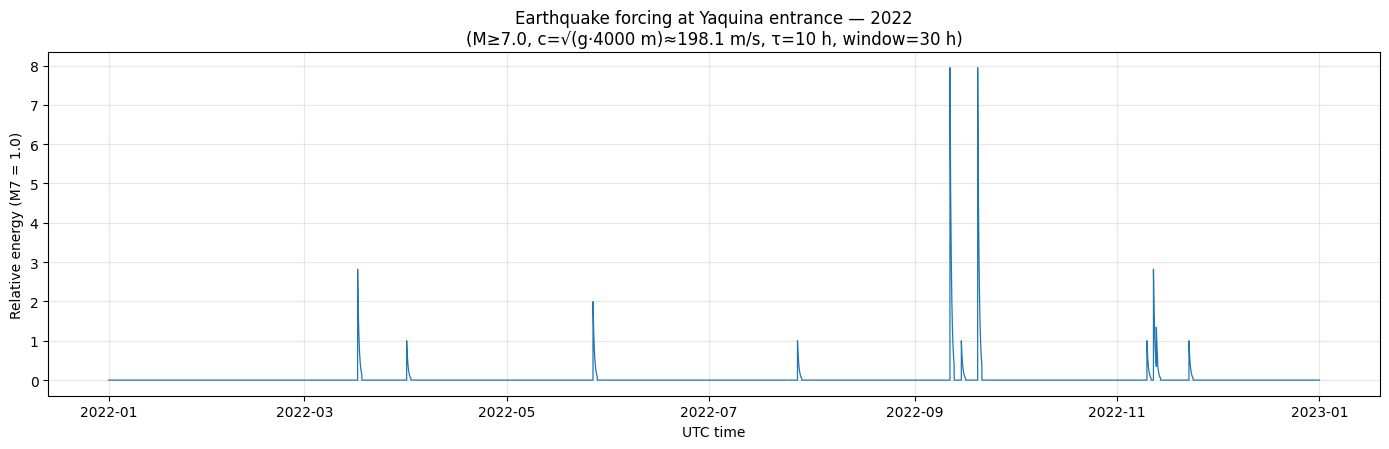

Grid coverage: 2008-01-01 00:00:00 → 2026-12-31 23:54:00 (n=1,665,600)
Nonzero samples: 60633


In [9]:
# ---------------- Config ----------------
START_ALL = "2008-01-01"
END_ALL   = "2026-12-31"
MINMAG    = 7.0
DT_MIN    = 6                  # 6-minute grid
TAU_HRS   = 10.0               # e-folding time constant
WINDOW_HRS= 30.0               # truncate after 30 h
H_DEPTH   = 4000.0             # m, deep-water sqrt(gh)
YAQ_LAT, YAQ_LON = 44.6250, -124.0670  # Yaquina Bay entrance (approx)

# Pacific basin bounds split across dateline
LAT_MIN, LAT_MAX = -60, 65
BOXES = [
    dict(minlongitude=110,  maxlongitude= 180, minlatitude=LAT_MIN, maxlatitude=LAT_MAX),  # W Pacific
    dict(minlongitude=-180, maxlongitude= -70, minlatitude=LAT_MIN, maxlatitude=LAT_MAX),  # E Pacific
]

# ---------------- Fetch USGS ----------------
BASE   = "https://earthquake.usgs.gov/fdsnws/event/1/query"
COMMON = dict(format="geojson", starttime=START_ALL, endtime=END_ALL,
              minmagnitude=MINMAG, orderby="time-asc", limit=20000)

session = requests.Session()
frames, urls_used = [], []
for box in BOXES:
    r = session.get(BASE, params={**COMMON, **box}, timeout=60)
    r.raise_for_status()
    urls_used.append(r.url)
    js = r.json()
    feats = js.get("features", [])
    if not feats:
        continue
    rows = []
    for f in feats:
        p = f.get("properties", {}) or {}
        g = f.get("geometry", {}) or {}
        coords = (g.get("coordinates") or [np.nan, np.nan, np.nan])
        lon, lat = coords[0], coords[1]
        t_ms = p.get("time")
        if t_ms is None:
            continue
        rows.append({
            "id":    f.get("id"),
            "time":  pd.to_datetime(t_ms, unit="ms", utc=True).tz_convert(None),
            "lat":   lat,
            "lon":   lon,
            "mag":   p.get("mag", np.nan),
            "place": p.get("place", "")
        })
    if rows:
        frames.append(pd.DataFrame(rows))

quakes = (pd.concat(frames, ignore_index=True)
            .drop_duplicates("id")
            .sort_values("time")
            .reset_index(drop=True)) if frames else pd.DataFrame(columns=["id","time","lat","lon","mag","place"])

print(f"Fetched M≥{MINMAG} events in Pacific {START_ALL}→{END_ALL}: {len(quakes)}")
if len(quakes)==0:
    raise SystemExit("No earthquakes found in range/bounds. Adjust filters and retry.")

# ---------------- Travel time → arrival ----------------
g = 9.81
c = np.sqrt(g * H_DEPTH)  # m/s

def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    φ1, φ2 = np.radians(lat1), np.radians(lat2)
    dφ = np.radians(lat2 - lat1)
    dλ = np.radians(lon2 - lon1)
    a = np.sin(dφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(dλ/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

dist_m = haversine_m(quakes["lat"].to_numpy(), quakes["lon"].to_numpy(), YAQ_LAT, YAQ_LON)
t_travel_s = dist_m / c
quakes["arrival"] = quakes["time"] + pd.to_timedelta(t_travel_s, unit="s")

# ---------------- Build full grid and paint all events ----------------
t0 = pd.to_datetime(START_ALL)
t1 = pd.to_datetime(END_ALL) + pd.Timedelta(days=1)   # inclusive end guard
t_grid = pd.date_range(t0, t1, freq=f"{DT_MIN}min", inclusive="left")
forcing = np.zeros(len(t_grid), dtype=float)

tau_s   = TAU_HRS * 3600.0
step_s  = DT_MIN * 60.0
K       = int(WINDOW_HRS*60/DT_MIN)
kernel  = np.exp(- np.arange(K+1, dtype=float) * (step_s/tau_s))  # length K+1

# Magnitude → relative energy scale (M7 baseline = 1.0)
scale = np.power(10.0, 1.5*(quakes["mag"].astype(float) - 7.0)).to_numpy()

# Paint each event without filtering: shift by travel time, then add decay
arr = quakes["arrival"].to_numpy("datetime64[ns]").astype("datetime64[ns]")
tg  = t_grid.to_numpy(dtype="datetime64[ns]")
tg_i64 = tg.astype("datetime64[ns]").astype("int64")
arr_i64= arr.astype("int64")

# vectorized searchsorted for starts
starts = np.searchsorted(tg_i64, arr_i64, side="left")
added = 0
for i, i0 in enumerate(starts):
    if np.isnan(scale[i]):
        continue
    if i0 >= len(forcing):          # arrival after grid
        continue
    j1 = min(i0 + K + 1, len(forcing))
    n  = j1 - i0
    if n <= 0:
        continue
    forcing[i0:j1] += scale[i] * kernel[:n]
    added += 1

print(f"Events painted into grid: {added} / {len(quakes)}")

# Package as DataFrame
eq_forcing = pd.DataFrame({"time": t_grid, "EQ_forcing": forcing})

# ---------------- Example slice/plot: year 2022 ----------------
view_year = 2022
mask = (eq_forcing["time"] >= f"{view_year}-01-01") & (eq_forcing["time"] < f"{view_year+1}-01-01")
df_2022 = eq_forcing.loc[mask].copy()

fig, ax = plt.subplots(figsize=(14,4.6))
ax.plot(df_2022["time"], df_2022["EQ_forcing"], lw=0.9)
ax.set_title(f"Earthquake forcing at Yaquina entrance — {view_year}\n"
             f"(M≥{MINMAG}, c=√(g·{H_DEPTH:.0f} m)≈{c:.1f} m/s, τ={TAU_HRS:g} h, window={WINDOW_HRS:g} h)")
ax.set_ylabel("Relative energy (M7 = 1.0)")
ax.set_xlabel("UTC time")
ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Quick sanity stats
print("Grid coverage:", eq_forcing["time"].min(), "→", eq_forcing["time"].max(), f"(n={len(eq_forcing):,})")
print("Nonzero samples:", np.count_nonzero(eq_forcing["EQ_forcing"]))


In [ ]:
# -------------------
# Common 6-min grid (based on available sources)
# -------------------
def _interp_timegrid(t_src:pd.Series, x_src:np.ndarray, t_grid:pd.DatetimeIndex)->np.ndarray:
    s = pd.Series(x_src, index=pd.to_datetime(t_src))
    u = s.reindex(pd.to_datetime(sorted(set(s.index).union(set(t_grid)))))
    u = u.interpolate(method="time", limit_area="inside")
    return u.reindex(pd.to_datetime(t_grid)).to_numpy()

t0_candidates=[]; t1_candidates=[]
for d,col in [(df_varWL,"time"), (df_wl6,"time"), (df_wind,"time"), (df_air_merged,"time"),
              (df_stdmet,"time"), (df_swden,"time")]:
    if len(d):
        t0_candidates.append(d[col].min()); t1_candidates.append(d[col].max())
if not t0_candidates:
    raise RuntimeError("No sources available; check API windows.")
t0 = max(t0_candidates); t1 = min(t1_candidates)
t_grid = pd.date_range(t0, t1, freq=f"{DT_MINUTES}min")

# -------------------
# Assemble seq_mat on grid (NO parquet; all online)
# -------------------
seq_mat = {}

# target: var_wl (requested)
seq_mat["var_wl"] = _interp_timegrid(df_varWL["time"], df_varWL["var_wl"].values, t_grid)

# WL raw (optional for QC)
seq_mat["wl"] = _interp_timegrid(df_wl6["time"], df_wl6["wl"].values, t_grid) if len(df_wl6) else np.full(len(t_grid), np.nan)

# wind to 6-min grid
if len(df_wind):
    seq_mat["wind9435380_speed"] = _interp_timegrid(df_wind["time"], df_wind["wind9435380_speed"].values, t_grid)
    seq_mat["wind9435380_dir"]   = _interp_timegrid(df_wind["time"], df_wind["wind9435380_dir"].values,   t_grid)

# air pressure (Pa) on 6-min grid
if len(df_air_merged):
    seq_mat["air_pressure_pa"] = _interp_timegrid(df_air_merged["time"], df_air_merged["air_pressure_pa"].values, t_grid)

# 46050 stdmet (EXCLUDE Hs from features, but keep for QC if you want)
if len(df_stdmet):
    for c in ["DPD","APD","MWD","Hs"]:
        seq_mat[c] = _interp_timegrid(df_stdmet["time"], df_stdmet[c].values, t_grid)

# 46050 swden bands
if len(df_swden):
    for c in ["high_HIG","Hswell","Hsea"]:
        seq_mat[c] = _interp_timegrid(df_swden["time"], df_swden[c].values, t_grid)

# Final dataframe
df_all = pd.DataFrame({"time": t_grid})
for k,v in seq_mat.items():
    df_all[k] = v

# --------------------------------
# USER KNOBS
# --------------------------------
YEARS                = list(range(2008, 2026))
DT_MINUTES           = 6                     # base grid
HISTORY_HOURS        = 12
HORIZONS_MIN         = [60, 120, 240]
PRIMARY_HORIZON      = 60
MAX_GAP_HOURS        = 5
TOP_LAG_FEATURES     = 16                   # keep a bit larger; we’ll still force baro features

# WL bandpass + variance
VAR_WIN_HOURS        = 2.0                  # centered rolling variance window (hours)
WL_BAND_MIN_MIN      = 20.0                 # minutes
WL_BAND_MAX_MIN      = 30.0                 # minutes

# NOAA stations + ranges
NOAA_WIND_STATION    = "9435380"            # Newport / South Beach (CO-OPS)
NOAA_BEGIN_DATE      = "20080101"
NOAA_END_DATE        = "20251001"
NOAA_CHUNK_DAYS      = 365
NOAA_WL_STATION      = "9435380"
WL_BEGIN_DATE        = "20080101"
WL_END_DATE          = "20251001"

# NDBC buoy 46050 spectra/stdmet
BUOY                 = "46050"

# HMSC monthly archive
HMSC_BASE_URL        = "http://weather.hmsc.oregonstate.edu/weather/weatherproject/archive/{yyyy}/HMSC_{yyyymm}.dat"
HMSC_UTC_OFFSET_H    = +8

# Barometric pressure high-pass + variance
BARO_HP_CUTOFF_H     = 4.0                  # high-pass cutoff (hours)
BARO_VAR_WIN_H       = 2.0                  # centered rolling variance (hours)
FORCE_BARO_IN_XGB    = True                 # force include baro features
BARO_FORCE_LAGS_MIN  = [0, 240]             # lags to try/force (minutes)

# Earthquake events (UTC) — add/edit as needed
EQ_EVENTS = [
    ("2011-03-11 05:46:00", 9.1),   # Tohoku
    ("2015-09-16 22:54:00", 8.3),   # Illapel, Chile
]
# EQ amplitude ~10^(M-7); decay tau (hours) ≈ 6.67*M - 30 (M9 ≈ 30h, M7.5 ≈ 20h)
EQ_DECAY_TAU_FUNC = lambda M: max(8.0, 6.6667 * M - 30.0)
EQ_AMPLITUDE_FUNC = lambda M: 10.0**(M - 7.0)

# Spike emphasis (targets) for PatchTST training
WEIGHT_SPIKES       = True
SPIKE_P90           = 0.90
SPIKE_WEIGHT        = 2.0

# PatchTST model knobs
PATCH_LEN           = 24      # 24*6min = 144 min patches
PATCH_STRIDE        = 6       # slide by 36 min
D_MODEL             = 192
NHEAD               = 4
NLAYERS             = 3
FF_DIM              = 384
DROPOUT             = 0.15
LR                  = 2e-3
EPOCHS              = 20
BATCH_SIZE          = 512

# Plot window
PRED_SPLIT          = "test"  # "test" or "val"
PRED_START          = pd.Timestamp("2022-11-01 00:00:00")
PRED_END            = pd.Timestamp("2022-12-20 23:59:59")
PLOT_LAST_DAYS      = 40

# Time splits
TRAIN_END           = pd.Timestamp("2018-12-31 23:59:59")
VAL_END             = pd.Timestamp("2022-12-31 23:59:59")
MAX_SAMPLES_SPLIT   = 60_000

# --------------------------------
# HTTP session with retries
# --------------------------------
def _make_session():
    s = requests.Session()
    retry = Retry(total=4, backoff_factor=0.6, status_forcelist=(429,500,502,503,504),
                  allowed_methods=["HEAD","GET","OPTIONS"], raise_on_status=False)
    s.headers.update({"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) SeichePatchTST/1.0", "Accept":"*/*"})
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://", HTTPAdapter(max_retries=retry))
    return s
session = _make_session()

def _ndbc_to_float(tok:str) -> float:
    s = str(tok).strip()
    if s == "" or s.upper() == "MM": return np.nan
    if re.fullmatch(r"-?9+(\.0+)?", s): return np.nan
    try: return float(s)
    except: return np.nan

def _datestr(dt) -> str:
    return pd.Timestamp(dt).strftime("%Y%m%d")

# --------------------------------
# NDBC 46050 STDMET (Hs/DPD/APD/MWD) — we will EXCLUDE Hs later
# --------------------------------
STDMET_PHP_PAT = f"https://www.ndbc.noaa.gov/view_text_file.php?filename={BUOY}h"+"{year}.txt.gz&dir=data/historical/stdmet/"

def fetch_stdmet_year(year:int)->str|None:
    for url in (STDMET_PHP_PAT.format(year=year),):
        try:
            r = session.get(url, timeout=40)
            if r.status_code==200 and r.text and "Page Not Found" not in r.text:
                return r.text
        except: pass
    return None

def parse_stdmet_text(txt:str)->pd.DataFrame:
    rows=[]
    for ln in txt.splitlines():
        if not ln or ln.lstrip().startswith("#"): continue
        parts = re.split(r"\s+", ln.strip())
        if len(parts) < 6: continue
        y,mo,dy,hh,mi = parts[:5]
        try:
            y=int(y); mo=int(mo); dy=int(dy); hh=int(hh); mi=int(mi)
            year = 2000+y if y<100 else y
            ts = pd.Timestamp(year=year, month=mo, day=dy, hour=hh, minute=mi, tz="UTC").tz_localize(None)
        except: continue
        vals = parts[5:]
        if len(vals) < 13: vals = (vals + ["MM"]*13)[:13]
        vals = [_ndbc_to_float(v) for v in vals]
        rows.append([ts] + vals)
    if not rows: return pd.DataFrame()
    cols = ["time","WDIR","WSPD","GST","WVHT","DPD","APD","MWD","PRES","ATMP","WTMP","DEWP","VIS","TIDE"]
    df = pd.DataFrame(rows, columns=cols).sort_values("time").drop_duplicates("time")
    df = df.rename(columns={"WVHT":"Hs"}).reset_index(drop=True)
    for c,thr in [("Hs",50.0),("DPD",50.0),("APD",50.0)]:
        if c in df.columns: df.loc[df[c]>thr, c]=np.nan
    df.loc[(df["MWD"]<0)|(df["MWD"]>360),"MWD"]=np.nan
    keep = ["time","Hs","DPD","APD","MWD"]
    for k in keep:
        if k not in df.columns: df[k]=np.nan
    return df[keep]

def build_stdmet(years: List[int]) -> pd.DataFrame:
    frames=[]
    for y in years:
        txt = fetch_stdmet_year(y)
        if not txt: continue
        dfy = parse_stdmet_text(txt)
        if not dfy.empty: frames.append(dfy)
    if not frames: return pd.DataFrame(columns=["time","Hs","DPD","APD","MWD"])
    return pd.concat(frames, ignore_index=True).sort_values("time").drop_duplicates("time").reset_index(drop=True)

df_stdmet = build_stdmet(YEARS)

# --------------------------------
# NDBC 46050 SWDEN → spectral bands high_HIG (<0.05Hz), Hswell (0.05–0.14Hz), Hsea (0.14–0.30Hz)
# --------------------------------
SWDEN_PHP_PATS = [
    f"https://www.ndbc.noaa.gov/view_text_file.php?filename={BUOY}w"+"{year}.txt.gz&dir=data/historical/swden/",
    f"https://www.ndbc.noaa.gov/view_text_file.php?filename={BUOY}w"+"{year}.txt.gz&dir=data/swden/"+BUOY+"/",
]

def fetch_swden_year(year:int)->str|None:
    for url in SWDEN_PHP_PATS:
        try:
            r = session.get(url.format(year=year), timeout=40)
            if r.status_code==200 and r.text and "Page Not Found" not in r.text:
                return r.text
        except: pass
    return None

def split_swden_blocks(lines:List[str]):
    header=[]; i=0
    while i<len(lines) and lines[i].startswith("#"):
        header.append(lines[i]); i+=1
    while i<len(lines) and not lines[i].strip():
        i+=1
    freq_line = lines[i].rstrip("\n") if i<len(lines) else None
    i += 1 if i<len(lines) else 0
    data=[ln for ln in lines[i:] if ln.strip()]
    return header, freq_line, data

def parse_swden_year(txt:str)->pd.DataFrame:
    lines = txt.splitlines()
    _, freq_line, data_lines = split_swden_blocks(lines)
    if not freq_line: return pd.DataFrame()
    freq_tokens = [t for t in re.split(r"\s+", freq_line.strip()) if t]
    if any(k in freq_tokens[:6] for k in ("YY","MM","DD","hh")):
        idx = lines.index(freq_line)
        j=idx+1
        while j<len(lines) and not lines[j].strip(): j+=1
        if j<len(lines):
            freq_tokens = [t for t in re.split(r"\s+", lines[j].strip()) if t]
            data_lines  = [ln for ln in lines[j+1:] if ln.strip()]
        else:
            return pd.DataFrame()

    def _num(tok):
        try: return float(tok)
        except: return np.nan
    freqs = np.array([_num(t) for t in freq_tokens], dtype=float)
    freqs = freqs[np.isfinite(freqs)]
    if freqs.size==0: return pd.DataFrame()

    dfw = np.empty_like(freqs)
    if freqs.size==1:
        dfw[:] = 0.0
    else:
        dfw[1:-1] = 0.5*(freqs[2:] - freqs[:-2])
        dfw[0]    = freqs[1] - freqs[0]
        dfw[-1]   = freqs[-1] - freqs[-2]
        dfw = np.where(dfw<0, np.nan, dfw)

    mask_hig   = (freqs < 0.05)
    mask_swell = (freqs >= 0.05) & (freqs <= 0.14)
    mask_sea   = (freqs > 0.14) & (freqs <= 0.30)

    rows=[]
    for ln in data_lines:
        parts = re.split(r"\s+", ln.strip())
        if len(parts) < 4: continue
        y,mo,dy,hh = parts[:4]
        try:
            y=int(y); mo=int(mo); dy=int(dy); hh=int(hh)
            year = 2000+y if y<100 else y
            ts = pd.Timestamp(year=year, month=mo, day=dy, hour=hh, tz="UTC").tz_localize(None)
        except: continue

        vals = np.array([_ndbc_to_float(v) for v in parts[4:]], dtype=float)
        if vals.size != freqs.size:
            if vals.size < freqs.size: vals = np.pad(vals, (0, freqs.size - vals.size), constant_values=np.nan)
            else: vals = vals[:freqs.size]

        def m0(mask): return np.nansum(vals[mask] * dfw[mask]) if mask.any() else np.nan
        high_HIG = 4.0*np.sqrt(m0(mask_hig))   if mask_hig.any()   else np.nan
        Hswell   = 4.0*np.sqrt(m0(mask_swell)) if mask_swell.any() else np.nan
        Hsea     = 4.0*np.sqrt(m0(mask_sea))   if mask_sea.any()   else np.nan
        rows.append((ts, high_HIG, Hswell, Hsea))

    if not rows: return pd.DataFrame()
    return (pd.DataFrame(rows, columns=["time","high_HIG","Hswell","Hsea"])
            .sort_values("time").drop_duplicates("time").reset_index(drop=True))

def build_swden(years: List[int]) -> pd.DataFrame:
    frames=[]
    for y in years:
        txt = fetch_swden_year(y)
        if not txt: continue
        dfy = parse_swden_year(txt)
        if not dfy.empty: frames.append(dfy)
    if not frames: return pd.DataFrame(columns=["time","high_HIG","Hswell","Hsea"])
    return pd.concat(frames, ignore_index=True).sort_values("time").drop_duplicates("time").reset_index(drop=True)

df_swden = build_swden(YEARS)

# --------------------------------
# NOAA CO-OPS wind (hourly) → speed, dir (no u/v in features)
# --------------------------------
def parse_noaa_wind_csv(txt:str)->pd.DataFrame:
    df = pd.read_csv(io.StringIO(txt))
    tcol = [c for c in df.columns if str(c).strip().lower() in ("t","time","date time","date_time","date")]
    tcol = tcol[0] if tcol else df.columns[0]
    df["time"] = pd.to_datetime(df[tcol], errors="coerce", utc=True).dt.tz_localize(None)
    def _find(keys):
        keys = [k.lower() for k in keys]
        for c in df.columns:
            s = str(c).lower()
            if any(k == s or k in s for k in keys): return c
        return None
    sp_col = _find(["s","speed"])
    dir_col= _find(["d","dir","direction"])
    out = pd.DataFrame({"time":df["time"]})
    out["wind_speed"] = pd.to_numeric(df[sp_col], errors="coerce") if sp_col else np.nan
    out["wind_dir"]   = pd.to_numeric(df[dir_col], errors="coerce") if dir_col else np.nan
    out.loc[(out["wind_dir"]<0)|(out["wind_dir"]>360),"wind_dir"]=np.nan
    out.loc[(out["wind_speed"]<0)|(out["wind_speed"]>100),"wind_speed"]=np.nan
    return (out.sort_values("time").dropna(subset=["time"])
            .drop_duplicates("time").reset_index(drop=True))

def fetch_noaa_wind_dataframe(begin_date:str, end_date:str, station:str, days_per_chunk:int=365)->pd.DataFrame:
    start = pd.to_datetime(begin_date, format="%Y%m%d"); end = pd.to_datetime(end_date, format="%Y%m%d")
    chunks=[]; cur=start
    while cur <= end:
        chunk_end = min(end, cur + pd.Timedelta(days=days_per_chunk-1))
        chunks.append((cur, chunk_end)); cur = chunk_end + pd.Timedelta(days=1)
    frames=[]
    for a,b in chunks:
        url = ("https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
               f"?begin_date={_datestr(a)}&end_date={_datestr(b)}"
               f"&station={station}&product=wind&time_zone=gmt&interval=h&units=metric"
               "&application=SeichePatchTST&format=csv")
        try:
            r = session.get(url, timeout=60)
            if r.status_code==200 and r.content:
                dfc = parse_noaa_wind_csv(r.content.decode("utf-8","ignore"))
                if not dfc.empty: frames.append(dfc)
        except: pass
    if not frames: return pd.DataFrame(columns=["time","wind_speed","wind_dir"])
    return pd.concat(frames, ignore_index=True).sort_values("time").drop_duplicates("time").reset_index(drop=True)

df_noaa_wind = fetch_noaa_wind_dataframe(NOAA_BEGIN_DATE, NOAA_END_DATE, NOAA_WIND_STATION, days_per_chunk=NOAA_CHUNK_DAYS)

# ================= NOAA + HMSC baro merge rules =================
# - NOAA air_pressure (hourly, metric) -> hPa -> Pa
# - HMSC AvgBP (inHg, 5-min) -> Pa
# - Fill NOAA gaps:
#     * runs >= 3 hours: fill from HMSC (on hourly grid)
#     * runs < 3 hours: spline interpolation (NOAA only)
# - Then interpolate merged Pa to t_grid and compute rolling variance

INHG_TO_PA = 3386.389  # 1 inch Hg ≈ 3386.389 Pa

# --- 1) Ensure df_air from NOAA exists (hourly), convert to Pa ---
if 'df_air' not in globals():
    raise RuntimeError("df_air (NOAA air pressure) is not defined. Fetch it first.")
df_air = df_air.dropna(subset=["time"]).drop_duplicates("time").sort_values("time").reset_index(drop=True)
df_air["air_pressure_pa"] = (df_air["air_pressure_hpa"].astype(float) * 100.0).astype("float64")

# Hourly base grid for merging/filling
ap_start = df_air["time"].min()
ap_end   = df_air["time"].max()
hourly_grid = pd.date_range(ap_start.floor("h"), ap_end.ceil("h"), freq="h")

s_noaa_pa = (df_air.set_index("time")["air_pressure_pa"]
             .reindex(hourly_grid)  # align to hourly
             .astype("float64"))

# --- 2) Build HMSC AvgBP (inHg) -> Pa over same window ---
def fetch_hmsc_month_text(year:int, month:int) -> str|None:
    url = f"http://weather.hmsc.oregonstate.edu/weather/weatherproject/archive/{year}/HMSC_{year}{month:02d}.dat"
    try:
        r = session.get(url, timeout=60)
        if r.status_code==200 and r.content:
            return r.content.decode("utf-8", "ignore")
    except Exception:
        pass
    return None

def parse_hmsc_dat_avgbp_pa(txt:str) -> pd.DataFrame:
    # Find the header line that starts the CSV (TIMESTAMP,...)
    lines = txt.splitlines()
    start_idx = None
    for i,ln in enumerate(lines):
        s = ln.strip().strip('"')
        if s.startswith("TIMESTAMP"):
            start_idx = i
            break
    if start_idx is None:
        return pd.DataFrame(columns=["time","bp_pa"])

    content = "\n".join(lines[start_idx:])
    df = pd.read_csv(io.StringIO(content))
    # Time
    t = parse_dt_series(df.iloc[:, 0])
    # Treat timestamps as America/Los_Angeles local, convert to UTC naive for merging with NOAA GMT
    try:
        t = t.dt.tz_localize("America/Los_Angeles", nonexistent="shift_forward", ambiguous="NaT") \
             .dt.tz_convert("UTC").dt.tz_localize(None)
    except Exception:
        # Fallback: assume already UTC if tz db not available
        pass

    df.rename(columns={df.columns[0]:"TIMESTAMP"}, inplace=True)

    # Find AvgBP column (case-insensitive match)
    target = None
    for c in df.columns:
        if "avgbp" in str(c).strip().lower():
            target = c; break
    if target is None:
        return pd.DataFrame(columns=["time","bp_pa"])

    avgbp_inhg = pd.to_numeric(df[target], errors="coerce").astype("float64")
    # sanity: realistic sea-level pressure in inches Hg (~27–32)
    avgbp_inhg = avgbp_inhg.where(avgbp_inhg.between(26.0, 33, inclusive="both"))

    out = pd.DataFrame({"time": t, "bp_pa": avgbp_inhg * INHG_TO_PA})
    out = (out.dropna(subset=["time"])
              .sort_values("time")
              .drop_duplicates("time")
              .reset_index(drop=True))
    return out

def month_iter(start:pd.Timestamp, end:pd.Timestamp):
    y,m = start.year, start.month
    while pd.Timestamp(year=y, month=m, day=1) <= end:
        yield (y,m)
        if m==12: y,m=y+1,1
        else: m+=1

# Fetch months that cover NOAA window (pad one month on each side)
start_pad = (ap_start - pd.Timedelta(days=31)).normalize()
end_pad   = (ap_end   + pd.Timedelta(days=31)).normalize()

hmsc_frames = []
for y,m in month_iter(start_pad, end_pad):
    txt = fetch_hmsc_month_text(y,m)
    if not txt: continue
    dfm = parse_hmsc_dat_avgbp_pa(txt)
    if not dfm.empty:
        # keep only within padded window to reduce size
        mask = (dfm["time"] >= start_pad) & (dfm["time"] <= end_pad)
        hmsc_frames.append(dfm.loc[mask])

df_hmsc_bp = (pd.concat(hmsc_frames, ignore_index=True)
              .sort_values("time")
              .drop_duplicates("time")
              .reset_index(drop=True)) if hmsc_frames else pd.DataFrame(columns=["time","bp_pa"])

# Resample HMSC bp to hourly with time interpolation (so we can drop into NOAA hourly gaps)
if len(df_hmsc_bp):
    s_hmsc_pa_hourly = (df_hmsc_bp.set_index("time")["bp_pa"]
                        .reindex(hourly_grid)
                        .interpolate(method="time", limit_area="inside")
                        .astype("float64"))
else:
    s_hmsc_pa_hourly = pd.Series(index=hourly_grid, dtype="float64")

# --- 3) Fill rules on hourly grid ---
filled = s_noaa_pa.copy()

# Identify contiguous NaN runs
nan_mask = filled.isna().to_numpy()
if nan_mask.any():
    # group NaN runs
    idx = np.arange(len(nan_mask))
    # start/end indices of each NaN block
    starts = np.where(~nan_mask[:-1] & nan_mask[1:])[0] + 1 if len(nan_mask) > 1 else np.array([], dtype=int)
    ends   = np.where(nan_mask[:-1] & ~nan_mask[1:])[0] + 1 if len(nan_mask) > 1 else np.array([], dtype=int)
    # edge cases
    if nan_mask[0]:  starts = np.r_[0, starts]
    if nan_mask[-1]: ends   = np.r_[ends, len(nan_mask)]

    for s,e in zip(starts, ends):
        run_len_hours = e - s  # hourly freq
        if run_len_hours >= 3:
            # >= 3h: fill from HMSC hourly if available
            seg_idx = hourly_grid[s:e]
            hmsc_vals = s_hmsc_pa_hourly.loc[seg_idx]
            filled.iloc[s:e] = hmsc_vals.values
    # For any remaining NaNs (i.e., runs < 3h or where HMSC missing), do spline on NOAA only
    if filled.isna().any():
        # spline requires some finite points; fall back to 'time' if sparse
        try:
            filled = filled.interpolate(method="spline", order=3, limit_area="inside")
        except Exception:
            filled = filled.interpolate(method="time", limit_area="inside")

# --- 4) Push merged Pa to your 6-min model grid and compute rolling variance ---
def _interp_to_grid_series(times: pd.DatetimeIndex, values: np.ndarray, grid: pd.DatetimeIndex) -> np.ndarray:
    s = pd.Series(values, index=times)
    u = s.reindex(pd.to_datetime(sorted(set(s.index).union(set(grid)))))
    u = u.interpolate(method="time", limit_area="inside")
    return u.reindex(pd.to_datetime(grid)).to_numpy()

if 't_grid' not in globals():
    if 'df_varWL' in globals() and len(df_varWL):
        t_grid = pd.date_range(df_varWL["time"].min(), df_varWL["time"].max(), freq=f"{DT_MINUTES}min")
    else:
        raise RuntimeError("t_grid is required to map air pressure to model grid.")

air_pa_on_grid = _interp_to_grid_series(hourly_grid, filled.to_numpy(dtype="float64"), t_grid)

# centered rolling variance in Pa^2
win = max(3, int(round((BARO_VAR_WIN_H*60.0)/DT_MINUTES)))  # BARO_VAR_WIN_H hours
minp = max(2, int(0.8*win))
baro_var = (pd.Series(air_pa_on_grid, index=t_grid)
            .rolling(window=win, center=True, min_periods=minp).var()
            .astype("float32"))

# --- 5) Inject into seq_mat and df_all ---
if 'seq_mat' not in globals():
    seq_mat = {}
seq_mat["air_pressure_pa"] = air_pa_on_grid.astype("float32")
seq_mat["baro_var4h"]      = baro_var.to_numpy(dtype="float32")  # keep name for downstream code

# Merge into df_all
base = pd.DataFrame({"time": t_grid, "air_pressure_pa": seq_mat["air_pressure_pa"], "baro_var4h": seq_mat["baro_var4h"]})
if 'df_all' in globals() and len(df_all):
    df_all = df_all.merge(base, on="time", how="left")
else:
    df_all = base.copy()

# Quick diagnostics
print("Air pressure (Pa) non-NaN on t_grid:", np.isfinite(seq_mat["air_pressure_pa"]).sum(), "/", len(t_grid))
print("baro_var4h non-NaN on t_grid:", np.isfinite(seq_mat["baro_var4h"]).sum(), "/", len(t_grid))

# --------------------------------
# WL (6-min) → bandpass(20–30 min) → centered variance (2 h)
# --------------------------------
from scipy.signal import butter, filtfilt

def parse_noaa_wl_csv(txt:str)->pd.DataFrame:
    if txt.strip().lower().startswith("error"):
        return pd.DataFrame(columns=["time","wl"])
    df = pd.read_csv(io.StringIO(txt))
    if df.shape[1] < 2: return pd.DataFrame(columns=["time","wl"])
    df.columns = [str(c).strip().lower().replace("  "," ") for c in df.columns]
    tcol=None
    for k in ("date time","date_time","time","t","date"):
        if k in df.columns: tcol=k; break
    if tcol is None: return pd.DataFrame(columns=["time","wl"])
    df["time"] = pd.to_datetime(df[tcol], errors="coerce", utc=True).dt.tz_localize(None)
    vcol=None
    for k in ("water level","water_level","wl","v"):
        if k in df.columns: vcol=k; break
    if vcol is None: vcol = df.columns[1]
    df["wl"] = pd.to_numeric(df[vcol], errors="coerce")
    out = df[["time","wl"]].dropna(subset=["time"]).sort_values("time").drop_duplicates("time")
    out.loc[(out["wl"]<-50)|(out["wl"]>50),"wl"]=np.nan
    if out["wl"].notna().sum()==0: return pd.DataFrame(columns=["time","wl"])
    return out.reset_index(drop=True)

def fetch_noaa_wl(begin_date:str, end_date:str, station:str, days_per_chunk:int=31)->pd.DataFrame:
    start = pd.to_datetime(begin_date, format="%Y%m%d"); end = pd.to_datetime(end_date, format="%Y%m%d")
    chunks=[]; cur=start
    while cur <= end:
        chunk_end = min(end, cur + pd.Timedelta(days=days_per_chunk-1))
        chunks.append((cur, chunk_end)); cur = chunk_end + pd.Timedelta(days=1)
    frames=[]
    for a,b in chunks:
        url = ("https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
               f"?begin_date={_datestr(a)}&end_date={_datestr(b)}"
               f"&station={station}&product=water_level&datum=MLLW&time_zone=gmt&units=metric"
               f"&interval=6&application=SeichePatchTST&format=csv")
        try:
            r = session.get(url, timeout=90)
            if r.status_code==200 and r.content:
                dfc = parse_noaa_wl_csv(r.content.decode("utf-8","ignore"))
                if not dfc.empty: frames.append(dfc)
        except: pass
    if not frames: return pd.DataFrame(columns=["time","wl"])
    return pd.concat(frames, ignore_index=True).sort_values("time").drop_duplicates("time").reset_index(drop=True)

def bandpass_then_var(series:pd.DataFrame, val_col:str, dt_minutes:int,
                      band_min_min:float, band_max_min:float, var_win_h:float)->pd.DataFrame:
    if series.empty: return pd.DataFrame(columns=["time","var"])
    t0,t1 = series["time"].min(), series["time"].max()
    grid = pd.date_range(t0.floor(f"{dt_minutes}min"), t1.ceil(f"{dt_minutes}min"), freq=f"{dt_minutes}min")
    s = series.set_index("time")[val_col].reindex(grid)
    s = s.interpolate(method="time", limit_area="inside")
    dt_sec = dt_minutes*60.0; fs=1.0/dt_sec
    f_lo = 1.0/(band_max_min*60.0)
    f_hi = 1.0/(band_min_min*60.0)
    wn = [max(1e-6, f_lo/(fs/2.0)), min(0.999, f_hi/(fs/2.0))]
    b,a = butter(6, wn, btype="bandpass")
    x = s.to_numpy(dtype=float)
    if np.isnan(x).any():
        idx = np.arange(len(x)); good = np.isfinite(x); x[~good] = np.interp(idx[~good], idx[good], x[good])
    x_bp = filtfilt(b,a,x,method="gust")
    win = max(3, int(round((var_win_h*60.0)/dt_minutes))); minp = max(2, int(0.8*win))
    var_series = pd.Series(x_bp, index=grid).rolling(window=win, center=True, min_periods=minp).var()
    return pd.DataFrame({"time":grid, "var":var_series.astype("float32")}).dropna(subset=["time"]).reset_index(drop=True)

def highpass_then_var(series:pd.DataFrame, val_col:str, dt_minutes:int,
                      hp_cutoff_h:float, var_win_h:float)->pd.DataFrame:
    """1st: high-pass (remove periods longer than hp_cutoff_h), then centered rolling variance."""
    if series.empty: return pd.DataFrame(columns=["time","var"])
    t0,t1 = series["time"].min(), series["time"].max()
    grid = pd.date_range(t0.floor(f"{dt_minutes}min"), t1.ceil(f"{dt_minutes}min"), freq=f"{dt_minutes}min")
    s = series.set_index("time")[val_col].reindex(grid)
    s = s.interpolate(method="time", limit_area="inside")
    dt_sec = dt_minutes*60.0; fs=1.0/dt_sec
    f_c = 1.0/(hp_cutoff_h*3600.0)  # Hz
    wn = max(1e-6, min(0.999, f_c/(fs/2.0)))
    b,a = butter(4, wn, btype="highpass")   # 4th order is plenty here
    x = s.to_numpy(dtype=float)
    if np.isnan(x).any():
        idx = np.arange(len(x)); good = np.isfinite(x); x[~good] = np.interp(idx[~good], idx[good], x[good])
    x_hp = filtfilt(b,a,x,method="gust")
    win = max(3, int(round((var_win_h*60.0)/dt_minutes))); minp = max(2, int(0.8*win))
    var_series = pd.Series(x_hp, index=grid).rolling(window=win, center=True, min_periods=minp).var()
    return pd.DataFrame({"time":grid, "var":var_series.astype("float32")}).dropna(subset=["time"]).reset_index(drop=True)

# --------------------------------
# Build all sources
# --------------------------------
df_wl6   = fetch_noaa_wl(WL_BEGIN_DATE, WL_END_DATE, NOAA_WL_STATION, days_per_chunk=31)
df_varWL = bandpass_then_var(df_wl6, "wl", DT_MINUTES, WL_BAND_MIN_MIN, WL_BAND_MAX_MIN, VAR_WIN_HOURS)

df_46050 = df_stdmet.copy()
df_swd   = df_swden.copy()

# Wind: choose coverage window from wind if present, else WL
if len(df_noaa_wind):
    fill_start, fill_end = df_noaa_wind["time"].min(), df_noaa_wind["time"].max()
else:
    candidates=[]
    if len(df_swd): candidates.append((df_swd["time"].min(), df_swd["time"].max()))
    if len(df_46050): candidates.append((df_46050["time"].min(), df_46050["time"].max()))
    if len(df_wl6): candidates.append((df_wl6["time"].min(), df_wl6["time"].max()))
    if candidates:
        fill_start = min(a for a,_ in candidates); fill_end = max(b for _,b in candidates)
    else:
        fill_start = pd.Timestamp("2008-01-01"); fill_end=pd.Timestamp("2025-10-01")
# ---- Put this once, before the first call to fetch_hmsc_range ----
def _empty_hmsc_range(t0, t1, tz="UTC"):
    """Hourly index [t0, t1] with NaNs in expected HMSC columns."""
    idx = pd.date_range(t0, t1, freq="1H", tz=tz)
    cols = {
        "wind_speed": np.nan,
        "wind_dir": np.nan,
        "air_pressure": np.nan,
        "gust": np.nan,
        # add other expected columns here if your code references them
    }
    return pd.DataFrame({k: np.full(len(idx), v) for k, v in cols.items()}, index=idx)

try:
    fetch_hmsc_range  # just checking it exists
except NameError:
    def fetch_hmsc_range(t0, t1, *args, **kwargs):
        """
        Fallback stub. Replace with your real implementation when ready.
        Must return a DataFrame indexed by UTC datetimes, hourly, with
        at least: wind_speed, wind_dir, air_pressure (and any columns
        your fill steps use).
        """
        if isinstance(t0, pd.Timestamp) and t0.tz is None:
            t0 = t0.tz_localize("UTC")
        if isinstance(t1, pd.Timestamp) and t1.tz is None:
            t1 = t1.tz_localize("UTC")
        return _empty_hmsc_range(t0, t1, tz="UTC")


# HMSC wind/dir/baro hourlies
df_hmsc = fetch_hmsc_range(fill_start, fill_end)

# Build unified hourly grid for wind fill
hourly_grid = pd.date_range(fill_start.floor("h"), fill_end.ceil("h"), freq="h")
noaa = (df_noaa_wind.set_index("time").reindex(hourly_grid).rename_axis("time").reset_index()) if len(df_noaa_wind) else pd.DataFrame({"time":hourly_grid})
noaa.rename(columns={"wind_speed":"speed","wind_dir":"dir"}, inplace=True)

if len(df_hmsc):
    hmsc = (df_hmsc.set_index("time").reindex(hourly_grid).rename_axis("time").reset_index())
else:
    hmsc = pd.DataFrame({"time":hourly_grid, "hmsc_speed_ms":np.nan,"hmsc_dir_deg":np.nan,"hmsc_baro_hpa":np.nan})

# fill wind speed/dir gaps from HMSC if both present
gap_mask = noaa[["speed","dir"]].isna().any(axis=1) if set(["speed","dir"]).issubset(noaa.columns) else pd.Series(True, index=noaa.index)
fillable = gap_mask & hmsc[["hmsc_speed_ms","hmsc_dir_deg"]].notna().all(axis=1)
noaa.loc[fillable, "speed"] = hmsc.loc[fillable, "hmsc_speed_ms"].values
noaa.loc[fillable, "dir"]   = hmsc.loc[fillable, "hmsc_dir_deg"].values

df_wind = pd.DataFrame({
    "time": noaa["time"],
    "wind9435380_speed": noaa.get("speed", pd.Series(index=noaa.index, dtype=float)).astype("float32"),
    "wind9435380_dir":   noaa.get("dir",   pd.Series(index=noaa.index, dtype=float)).astype("float32"),
}).dropna(subset=["time"]).reset_index(drop=True)

# Baro (hourly) from HMSC if present → highpass + variance
if "hmsc_baro_hpa" in hmsc.columns and hmsc["hmsc_baro_hpa"].notna().any():
    df_baro = hmsc[["time","hmsc_baro_hpa"]].copy()
    df_baro = df_baro.dropna(subset=["time"]).drop_duplicates("time").sort_values("time").reset_index(drop=True)
    df_baro_var = highpass_then_var(df_baro, "hmsc_baro_hpa", 60, BARO_HP_CUTOFF_H, BARO_VAR_WIN_H)
else:
    df_baro = pd.DataFrame(columns=["time","hmsc_baro_hpa"])
    df_baro_var = pd.DataFrame(columns=["time","var"])

# --------------------------------
# Build common DT grid + assemble inputs
# --------------------------------
def interp_timegrid(t_src:pd.Series, x_src:np.ndarray, t_grid:pd.DatetimeIndex)->np.ndarray:
    s = pd.Series(x_src, index=pd.to_datetime(t_src))
    u = s.reindex(pd.to_datetime(sorted(set(s.index).union(set(t_grid)))))
    u = u.interpolate(method="time", limit_area="inside")
    return u.reindex(pd.to_datetime(t_grid)).to_numpy()

# overlap
t0_candidates = [df_varWL["time"].min()] if len(df_varWL) else []
t1_candidates = [df_varWL["time"].max()] if len(df_varWL) else []
for d, col in [(df_swd,"time"), (df_46050,"time"), (df_wind,"time"), (df_baro,"time"), (df_baro_var,"time")]:
    if len(d):
        t0_candidates.append(d[col].min()); t1_candidates.append(d[col].max())
t0 = max(t0_candidates); t1 = min(t1_candidates)
t_grid = pd.date_range(t0, t1, freq=f"{DT_MINUTES}min")

# target
var_on_grid = interp_timegrid(df_varWL["time"], df_varWL["var"].values, t_grid)

# inputs
seq_mat = {}
if len(df_swd):
    seq_mat["high_HIG"] = interp_timegrid(df_swd["time"], df_swd["high_HIG"].values, t_grid)
    seq_mat["Hswell"]   = interp_timegrid(df_swd["time"], df_swd["Hswell"].values, t_grid)
    seq_mat["Hsea"]     = interp_timegrid(df_swd["time"], df_swd["Hsea"].values, t_grid)

for c in ["DPD","APD","MWD"]:  # EXCLUDE Hs
    if len(df_46050):
        seq_mat[c] = interp_timegrid(df_46050["time"], df_46050[c].values, t_grid)

if len(df_wind):
    seq_mat["wind9435380_speed"] = interp_timegrid(df_wind["time"], df_wind["wind9435380_speed"].values, t_grid)
    seq_mat["wind9435380_dir"]   = interp_timegrid(df_wind["time"], df_wind["wind9435380_dir"].values,   t_grid)

if len(df_baro):
    seq_mat["hmsc_baro_hpa"] = interp_timegrid(df_baro["time"], df_baro["hmsc_baro_hpa"].values, t_grid)
if len(df_baro_var):
    seq_mat["baro_var4h"] = interp_timegrid(df_baro_var["time"], df_baro_var["var"].values, t_grid)
else:
    seq_mat["baro_var4h"] = np.full(len(t_grid), np.nan, dtype=float)

# EQ_decay
def build_eq_decay_series(t_grid: pd.DatetimeIndex, eq_events: list[tuple[str|pd.Timestamp, float]]) -> np.ndarray:
    if not eq_events or len(t_grid)==0:
        return np.zeros(len(t_grid), dtype=float)
    out = np.zeros(len(t_grid), dtype=float)
    for t0_evt, M in eq_events:
        t0_evt = pd.Timestamp(t0_evt)
        amp = float(EQ_AMPLITUDE_FUNC(float(M)))
        tau_h = float(EQ_DECAY_TAU_FUNC(float(M))); tau_s = max(1.0, tau_h*3600.0)
        dt = (t_grid - t0_evt).total_seconds().astype(float)
        m = dt >= 0.0
        out[m] += amp * np.exp(-dt[m] / tau_s)
    return out

seq_mat["EQ_decay"] = build_eq_decay_series(t_grid, EQ_EVENTS)

# Unified gap mask (use the major channels)
def gap_intervals(t:pd.Series, x:np.ndarray, min_gap_hours:float)->List[Tuple[pd.Timestamp,pd.Timestamp]]:
    t = pd.to_datetime(t)
    if len(t) < 2: return []
    dt = np.diff(t.values).astype("timedelta64[s]").astype(int)
    jumps = np.where(dt > min_gap_hours*3600)[0]
    iv = [(t[j], t[j+1]) for j in jumps]
    s = pd.Series(x, index=t)
    isn = s.isna().to_numpy()
    if isn.any():
        starts = np.where(np.diff(np.r_[False, isn])==1)[0]
        ends   = np.where(np.diff(np.r_[isn, False])==-1)[0]
        for a,b in zip(starts, ends):
            if (t[b]-t[a]) >= pd.Timedelta(hours=min_gap_hours):
                iv.append((t[a], t[b]))
    return iv

def merge_intervals(intervals):
    if not intervals: return []
    z = sorted(intervals, key=lambda k: k[0]); out = [list(z[0])]
    for s,e in z[1:]:
        if s <= out[-1][1]: out[-1][1] = max(out[-1][1], e)
        else: out.append([s,e])
    return [(pd.to_datetime(a), pd.to_datetime(b)) for a,b in out]

all_intervals=[]
if len(df_swd):
    for c in ["high_HIG","Hswell","Hsea"]:
        all_intervals += gap_intervals(df_swd["time"], df_swd[c].values, MAX_GAP_HOURS)
if len(df_46050):
    for c in ["DPD","APD","MWD"]:
        all_intervals += gap_intervals(df_46050["time"], df_46050[c].values, MAX_GAP_HOURS)
if len(df_wind):
    for c in ["wind9435380_speed","wind9435380_dir"]:
        all_intervals += gap_intervals(df_wind["time"], df_wind[c].values, MAX_GAP_HOURS)
if len(df_baro):
    all_intervals += gap_intervals(df_baro["time"], df_baro["hmsc_baro_hpa"].values, MAX_GAP_HOURS)

merged_gaps = merge_intervals(all_intervals)
gap_mask = np.zeros(len(t_grid), dtype=bool)
for s,e in merged_gaps:
    gap_mask |= (t_grid>=s) & (t_grid<=e)

# Assemble df_all (target + inputs)
df_all = pd.DataFrame({"time": t_grid, "var1h": var_on_grid})
for c,v in seq_mat.items():
    df_all[c] = v
df_all = df_all.loc[~gap_mask].reset_index(drop=True)

# Post-align cleaning for stdmet heads
for col, thresh in [("DPD",50.0),("APD",50.0)]:
    if col in df_all.columns:
        m = df_all[col] > thresh
        if m.any(): df_all.loc[m, col] = np.nan
        df_all[col] = pd.Series(df_all[col].values, index=df_all["time"]).interpolate("time", limit_area="inside").values
# --------------------------------
# Lag features + XGB pick (force baro)
# --------------------------------
NON_EQ_MAX_LAG_MIN  = 4 * 60
EQ_MAX_LAG_MIN      = 24 * 60

def is_eq_base(name: str) -> bool:
    n = name.lower()
    return n.startswith("eq") or ("eq_" in n)

def build_lag_candidates(df: pd.DataFrame, bases: List[str], dt_minutes: int,
                         step_minutes: int = 30) -> Tuple[pd.DataFrame, List[str], Dict[str, str], Dict[str, int]]:
    lag_cols, series = [], {}
    base_map, lag_minutes_map = {}, {}
    for b in bases:
        x = df[b].astype("float32").to_numpy()
        if not np.isfinite(x).any(): continue
        max_lag_min = EQ_MAX_LAG_MIN if is_eq_base(b) else NON_EQ_MAX_LAG_MIN
        grid_min = list(range(0, max_lag_min + 1, int(step_minutes)))
        for L in grid_min:
            steps = int(round(L / dt_minutes))
            nm = f"{b}__lag_{L}min"
            lag_minutes_map[nm] = L; base_map[nm] = b
            if steps == 0:
                series[nm] = x
            else:
                s = pd.Series(x); series[nm] = s.shift(steps).to_numpy(dtype="float32")
            lag_cols.append(nm)
    lag_df = pd.DataFrame(series).reindex(range(len(df))).reset_index(drop=True)
    return lag_df, lag_cols, base_map, lag_minutes_map

# Exclude Hs explicitly; include everything else numeric
exclude_cols = set(["time","var1h","Hs"])  # drop Hs — redundant with spectral bands
cand_bases = [c for c in df_all.columns if (c not in exclude_cols and df_all[c].dtype != object)]

lag_df, lag_cols, base_map, lag_minutes_map = build_lag_candidates(df_all, cand_bases, DT_MINUTES)

# XGB rank one best per base
from xgboost import XGBRegressor
h_steps = max(1, int(round(PRIMARY_HORIZON / DT_MINUTES)))
tgt = df_all["var1h"].shift(-h_steps).reset_index(drop=True).astype("float32")
rank_data = pd.concat([lag_df, tgt.rename("target")], axis=1).dropna().reset_index(drop=True)
if rank_data.empty: raise RuntimeError("No data for XGB ranking; check coverage.")

X_rank = rank_data[lag_cols].to_numpy(dtype=np.float32)
y_rank = rank_data["target"].to_numpy(dtype=np.float32)

# existing code
X_rank = rank_data[lag_cols].to_numpy(dtype=np.float32)
y_rank = rank_data["target"].to_numpy(dtype=np.float32)

# === start Optuna integration ===
import optuna
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# split ranking data (80/20) for tuning
split_idx = max(1, int(0.8 * len(X_rank)))
X_train, X_val = X_rank[:split_idx], X_rank[split_idx:]
y_train, y_val = y_rank[:split_idx], y_rank[split_idx:]

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 10.0),
    }
    tree_method = "gpu_hist" if torch.cuda.is_available() else "hist"
    model = XGBRegressor(
        objective="reg:squarederror",
        tree_method=tree_method,
        random_state=42,
        n_jobs=-1,
        **params
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
              eval_metric="rmse", verbose=False, early_stopping_rounds=50)
    preds = model.predict(X_val)
    return mean_squared_error(y_val, preds)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

best_params = study.best_params
best_params.update({"objective": "reg:squarederror",
                    "tree_method": ("gpu_hist" if torch.cuda.is_available() else "hist"),
                    "random_state": 42,
                    "n_jobs": -1})
xgb_opt = XGBRegressor(**best_params)
xgb_opt.fit(X_rank, y_rank, verbose=False)

importances = dict(zip(lag_cols, xgb_opt.feature_importances_))

best_lag_per_base = {}
for nm, imp in importances.items():
    b = base_map[nm]
    prev = best_lag_per_base.get(b)
    if (prev is None) or (imp > prev[1]): best_lag_per_base[b] = (nm, float(imp))
best_list = [(b, nm, imp) for b,(nm,imp) in best_lag_per_base.items()]
best_list.sort(key=lambda t: t[2], reverse=True)
best_list = best_list[:TOP_LAG_FEATURES]

selected_lag_cols = [nm for _, nm, _ in best_list]
selected_bases    = [b  for b, _, _ in best_list]

# Force include baro features (and EQ if you want to guarantee)
def _prefer_lags(base_name:str, pref_lags:list[int])->str|None:
    for L in pref_lags:
        nm = f"{base_name}__lag_{L}min"
        if nm in lag_cols: return nm
    cands = [nm for nm in lag_cols if base_map.get(nm)==base_name]
    if not cands: return None
    return max(cands, key=lambda z: importances.get(z, 0.0))

for base in ["baro_var4h", "hmsc_baro_hpa", "EQ_decay"]:
    nm = _prefer_lags(base, BARO_FORCE_LAGS_MIN if base!="EQ_decay" else [0,240])
    if nm and nm not in selected_lag_cols:
        selected_lag_cols.append(nm); selected_bases.append(base)

print("\nSelected ONE best lag per base (forced baro/EQ included if available):")
for nm in selected_lag_cols:
    b = base_map[nm]
    imp = importances.get(nm, 0.0)
    print(f"  {nm:<32s} base={b:<16s} imp={imp:.6f} lag={lag_minutes_map[nm]}")

# Assemble minimal lag table
df_lag_all = pd.concat(
    [df_all[["time", "var1h"]].reset_index(drop=True),
     lag_df[selected_lag_cols].reset_index(drop=True)],
    axis=1
)

# --------------------------------
# PatchTST model & training
# --------------------------------
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

use_gpu = torch.cuda.is_available()
if use_gpu:
    torch.backends.cudnn.benchmark = True
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")
def _amp_ctx(): return nullcontext()

class PatchEmbedding(nn.Module):
    def __init__(self, in_features:int, patch_len:int, stride:int, d_model:int):
        super().__init__()
        self.patch_len = patch_len
        self.stride    = stride
        self.proj      = nn.Linear(in_features*patch_len, d_model)
    def forward(self, x):
        B,T,F = x.shape
        N = 1 + (T - self.patch_len)//self.stride
        patches = []
        for i in range(N):
            s = i*self.stride; e = s + self.patch_len
            seg = x[:, s:e, :].reshape(B, -1)
            patches.append(seg)
        P = torch.stack(patches, dim=1)  # (B,N,F*patch_len)
        return self.proj(P)              # (B,N,d)

class PatchTST(nn.Module):
    def __init__(self, in_features, patch_len, stride, d_model=128, nhead=4, nlayers=3, ff_dim=256, drop=0.2):
        super().__init__()
        self.embed = PatchEmbedding(in_features, patch_len, stride, d_model)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=ff_dim,
                                           dropout=drop, batch_first=True, norm_first=True)
        self.enc  = nn.TransformerEncoder(layer, num_layers=nlayers)
        self.head = nn.Sequential(nn.Linear(d_model, d_model//2), nn.ReLU(), nn.Linear(d_model//2, 1))
    def forward(self, x):
        z = self.embed(x); z = self.enc(z)
        return self.head(z[:, -1, :]).squeeze(-1)

def rmse(a,b): return float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))

# scaling helpers
def _safe_robust_params(X: np.ndarray, q_low=25.0, q_high=75.0, eps=1e-6):
    Xf = X.reshape(-1, X.shape[2])
    med = np.nanmedian(Xf, axis=0)
    q1  = np.nanpercentile(Xf, q_low, axis=0)
    q3  = np.nanpercentile(Xf, q_high, axis=0)
    iqr = q3 - q1
    scale = np.where(iqr <= eps, 1.0, iqr)
    return med.astype(np.float32), scale.astype(np.float32)

def fit_scaler_from_windows_safe(X_tr, X_va=None, X_te=None):
    for X in (X_tr, X_va, X_te):
        if X is not None and len(X) > 0:
            med, scale = _safe_robust_params(X)
            return {"center": med, "scale": scale}
    F = X_tr.shape[2] if (X_tr is not None and X_tr.size) else (
        X_va.shape[2] if (X_va is not None and X_va.size) else (
        X_te.shape[2] if (X_te is not None and X_te.size) else 1))
    return {"center": np.zeros(F, np.float32), "scale": np.ones(F, np.float32)}

def norm_windows(X, rs, clip=20.0):
    if len(X) == 0: return X
    F = X.shape[2]
    C = rs["center"].reshape(1, 1, F)
    S = rs["scale" ].reshape(1, 1, F)
    Z = (X - C) / S
    Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    if clip is not None: Z = np.clip(Z, -clip, clip, out=Z)
    return Z

def make_windows_from_lagged(df:pd.DataFrame, lag_cols:List[str],
                             history_hours:int, horizon_min:int, dt_minutes:int,
                             stride:int=1):
    steps_hist  = int(round(history_hours*60/dt_minutes))
    steps_ahead = int(round(horizon_min/dt_minutes))
    tab = df[["time","var1h"] + lag_cols].copy()
    tab = tab.dropna(subset=lag_cols + ["var1h"]).reset_index(drop=True)
    if len(tab) < steps_hist + steps_ahead + 1:
        return np.empty((0,steps_hist,len(lag_cols))), np.empty((0,)), pd.DatetimeIndex([])
    X_list, y_list, t_list = [], [], []
    F = len(lag_cols); Ttot = len(tab)
    for end_idx in range(steps_hist, Ttot - steps_ahead + 1, stride):
        s = end_idx - steps_hist
        k = end_idx - 1 + steps_ahead
        xb = tab.iloc[s:end_idx][lag_cols].values
        yv = tab.iloc[k]["var1h"]
        if np.any(~np.isfinite(xb)) or not np.isfinite(yv): continue
        X_list.append(xb.astype(np.float32))
        y_list.append(float(yv))
        t_list.append(pd.to_datetime(tab.iloc[k]["time"]))
    if not X_list:
        return np.empty((0,steps_hist,F)), np.empty((0,)), pd.DatetimeIndex([])
    return np.stack(X_list), np.array(y_list, dtype=np.float32), pd.DatetimeIndex(t_list)

def adaptive_index_split(X, y, t_idx, train_frac=0.70, val_frac=0.15):
    n = len(X)
    if n < 10:
        return (X[:0], y[:0], t_idx[:0]), (X[:0], y[:0], t_idx[:0]), (X, y, t_idx)
    a = max(1, int(round(train_frac * n)))
    b = max(a+1, int(round((train_frac + val_frac) * n)))
    b = min(b, n-1)
    return (X[:a], y[:a], t_idx[:a]), (X[a:b], y[a:b], t_idx[a:b]), (X[b:], y[b:], t_idx[b:])

def cap_split(X_, y_, t_, cap=MAX_SAMPLES_SPLIT):
    if len(X_) <= cap: return X_, y_, t_
    idx = np.linspace(0, len(X_) - 1, cap, dtype=int)
    return X_[idx], y_[idx], t_[idx]

def _fmt(ts):
    return ts.strftime("%Y-%m-%d %H:%M") if (ts is not None and pd.notna(ts)) else "—"

def print_split_summary(horizon, t_tr, t_va, t_te):
    def rng(t):
        if len(t)==0: return (None,None,0)
        return (t.min(), t.max(), len(t))
    tr0,tr1,ntr = rng(t_tr); va0,va1,nva = rng(t_va); te0,te1,nte = rng(t_te)
    print(f"[{horizon}m] Split ranges:")
    print(f"  Train: {_fmt(tr0)} → {_fmt(tr1)}  (n={ntr})")
    print(f"  Valid: {_fmt(va0)} → {_fmt(va1)}  (n={nva})")
    print(f"  Test : {_fmt(te0)} → {_fmt(te1)}  (n={nte})")
    return (tr0,tr1),(va0,va1),(te0,te1)

# --------------------------------
# Train PatchTST across horizons
# --------------------------------
results = {}
for horizon in HORIZONS_MIN:
    print(f"\n=== Horizon {horizon} min ===")
    X, y, t_idx = make_windows_from_lagged(df_lag_all, selected_lag_cols,
                                           HISTORY_HOURS, horizon, DT_MINUTES, stride=1)

    if len(t_idx):
        print(f"[{horizon}m] Windows available:", t_idx.min(), "→", t_idx.max(), f"(n={len(t_idx):,})")
    else:
        print(f"[{horizon}m] No windows after lagging/masking."); continue

    mtr = t_idx <= TRAIN_END
    mva = (t_idx > TRAIN_END) & (t_idx <= VAL_END)
    mte = t_idx > VAL_END

    X_tr, y_tr, t_tr = X[mtr], y[mtr], t_idx[mtr]
    X_va, y_va, t_va = X[mva], y[mva], t_idx[mva]
    X_te, y_te, t_te = X[mte], y[mte], t_idx[mte]

    if len(X_tr)==0 or len(X_va)==0 or len(X_te)==0:
        print("  Time split empty; using adaptive 70/15/15.")
        (X_tr, y_tr, t_tr), (X_va, y_va, t_va), (X_te, y_te, t_te) = adaptive_index_split(X, y, t_idx)
    if len(X_te)==0:
        n=len(X); cut=max(1,int(0.85*n))
        X_tr,y_tr,t_tr = X[:cut],y[:cut],t_idx[:cut]
        X_va,y_va,t_va = X[:0],y[:0],t_idx[:0]
        X_te,y_te,t_te = X[cut:],y[cut:],t_idx[cut:]

    _ = print_split_summary(horizon, t_tr, t_va, t_te)

    # scale
    rs     = fit_scaler_from_windows_safe(X_tr, X_va, X_te)
    X_tr_n = norm_windows(X_tr, rs); X_va_n = norm_windows(X_va, rs); X_te_n = norm_windows(X_te, rs)

    # model
    device = torch.device("cuda" if use_gpu else "cpu")
    model = PatchTST(
        in_features=X_tr_n.shape[2], patch_len=PATCH_LEN, stride=PATCH_STRIDE,
        d_model=D_MODEL, nhead=NHEAD, nlayers=NLAYERS, ff_dim=FF_DIM, drop=DROPOUT
    ).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss(reduction="none")

    ds_tr = TensorDataset(torch.from_numpy(X_tr_n), torch.from_numpy(y_tr))
    ds_va = TensorDataset(torch.from_numpy(X_va_n), torch.from_numpy(y_va))
    dl_tr = DataLoader(ds_tr, batch_size=min(BATCH_SIZE, len(ds_tr)), shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=min(BATCH_SIZE, len(ds_va)), shuffle=False, drop_last=False)

    best = np.inf; best_state=None; patience=3; bad=0
    q = np.quantile(y_tr, SPIKE_P90) if (WEIGHT_SPIKES and len(y_tr)>0) else None

    for ep in range(EPOCHS):
        model.train(); tr_loss=0.0
        for xb,yb in dl_tr:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            with _amp_ctx():
                pred = model(xb)
                l = (pred - yb) ** 2
                if q is not None:
                    w = torch.where(yb >= torch.tensor(q, device=yb.device, dtype=yb.dtype),
                                    torch.tensor(SPIKE_WEIGHT, device=yb.device, dtype=yb.dtype),
                                    torch.tensor(1.0,         device=yb.device, dtype=yb.dtype))
                    l = l * w
                loss = l.mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            tr_loss += loss.item() * len(xb)
        tr_loss /= max(1, len(dl_tr.dataset))

        model.eval(); va_loss=0.0
        with torch.no_grad(), _amp_ctx():
            for xb,yb in dl_va:
                xb,yb = xb.to(device), yb.to(device)
                out = model(xb)
                va_loss += nn.functional.mse_loss(out, yb, reduction="sum").item()
        va_loss /= max(1, len(dl_va.dataset))
        print(f"[PatchTST] epoch {ep+1:02d}  trainMSE={tr_loss:.5f}  valMSE={va_loss:.5f}")

        if va_loss + 1e-6 < best:
            best = va_loss; best_state = model.state_dict(); bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("[PatchTST] early stop."); break
    if best_state is not None:
        model.load_state_dict(best_state)

    # predict
    def predict_patchtst(model, X):
        ds = TensorDataset(torch.from_numpy(X))
        dl = DataLoader(ds, batch_size=min(BATCH_SIZE, len(ds)), shuffle=False, drop_last=False)
        out=[]; model.eval()
        with torch.no_grad(), _amp_ctx():
            for (xb,) in dl:
                xb = xb.to(device)
                out.append(model(xb).cpu().numpy())
        return np.concatenate(out, axis=0) if len(out)>0 else np.array([])

    yp_va = predict_patchtst(model, X_va_n) if len(X_va_n)>0 else np.array([])
    yp_te = predict_patchtst(model, X_te_n) if len(X_te_n)>0 else np.array([])

    def _rmse(a,b):
        return float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2))) if len(a)==len(b) and len(a)>0 else float("nan")

    R2 = r2_score(y_te, yp_te) if len(yp_te)>0 and len(y_te)>0 else float("nan")
    RMSE = _rmse(y_te, yp_te)
    results[horizon] = dict(t_val=t_va, y_val=y_va, yp_val=yp_va,
                            t=t_te, y=y_te, yp=yp_te, r2=R2, rmse=RMSE)
    print(f"[PatchTST] {horizon}m  Test R²={R2:.3f}  RMSE={RMSE:.3f}")

    # plots
    if PRED_SPLIT.lower() == "val":
        t_plot, y_plot, yhat_plot = t_va, y_va, yp_va; split_name="Validation"
    else:
        t_plot, y_plot, yhat_plot = t_te, y_te, yp_te; split_name="Test"
    if len(t_plot)==0: continue

    mwin = (t_plot >= PRED_START) & (t_plot <= PRED_END)
    if not np.any(mwin):
        end = t_plot[-1]; start = end - pd.Timedelta(days=PLOT_LAST_DAYS)
        mwin = (t_plot >= start) & (t_plot <= end)

    if np.any(mwin):
        ts, yt, ypp = t_plot[mwin], y_plot[mwin], yhat_plot[mwin]
        plt.figure(figsize=(14,4))
        plt.plot(ts, yt, label="Measured", lw=1.2)
        plt.plot(ts, ypp, "--", label=f"Predicted ({split_name})", lw=1.2)
        plt.title(f"PatchTST — {horizon} min ({split_name})")
        plt.ylabel("var1h"); plt.xlabel("Time"); plt.grid(alpha=0.3); plt.legend()
        plt.tight_layout(); plt.show()

print("\nFinal selected lag channels (one per base):")
for nm in selected_lag_cols:
    print("  ", nm)
